In [22]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

from main import load_and_prepare_sessions
from analysis.performance_funcs import add_performance_container
from processing.timepoint_analysis import aggregate_signals
from data.mouse import create_mice_dict

from collections import defaultdict
import matplotlib.pyplot as plt

sessions = load_and_prepare_sessions("../../Baseline", load_from_pickle=True, remove_bad_signal_sessions=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
mice_dict = create_mice_dict(sessions)

In [24]:
for mouse in mice_dict.values():
    add_performance_container(mouse)

In [25]:
# get a sorted argidx list of 

In [26]:
session_metric_order = defaultdict(list)

for mouse in mice_dict.values():
    for metric, item in mouse.metric_container.data.items():
        session_metric_order[metric] += zip(mouse.session_idxs, [item] * len(mouse.session_idxs))

metric_session_order = {}
for metric in session_metric_order.keys():
    sorted_metrics = sorted(session_metric_order[metric], key=lambda t: t[-1])
    metric_session_order[metric] = list(zip(*sorted_metrics))[0]

In [ ]:
list(zip(metric_session_order['c_score'], metric_session_order['d_prime'][::-1]))

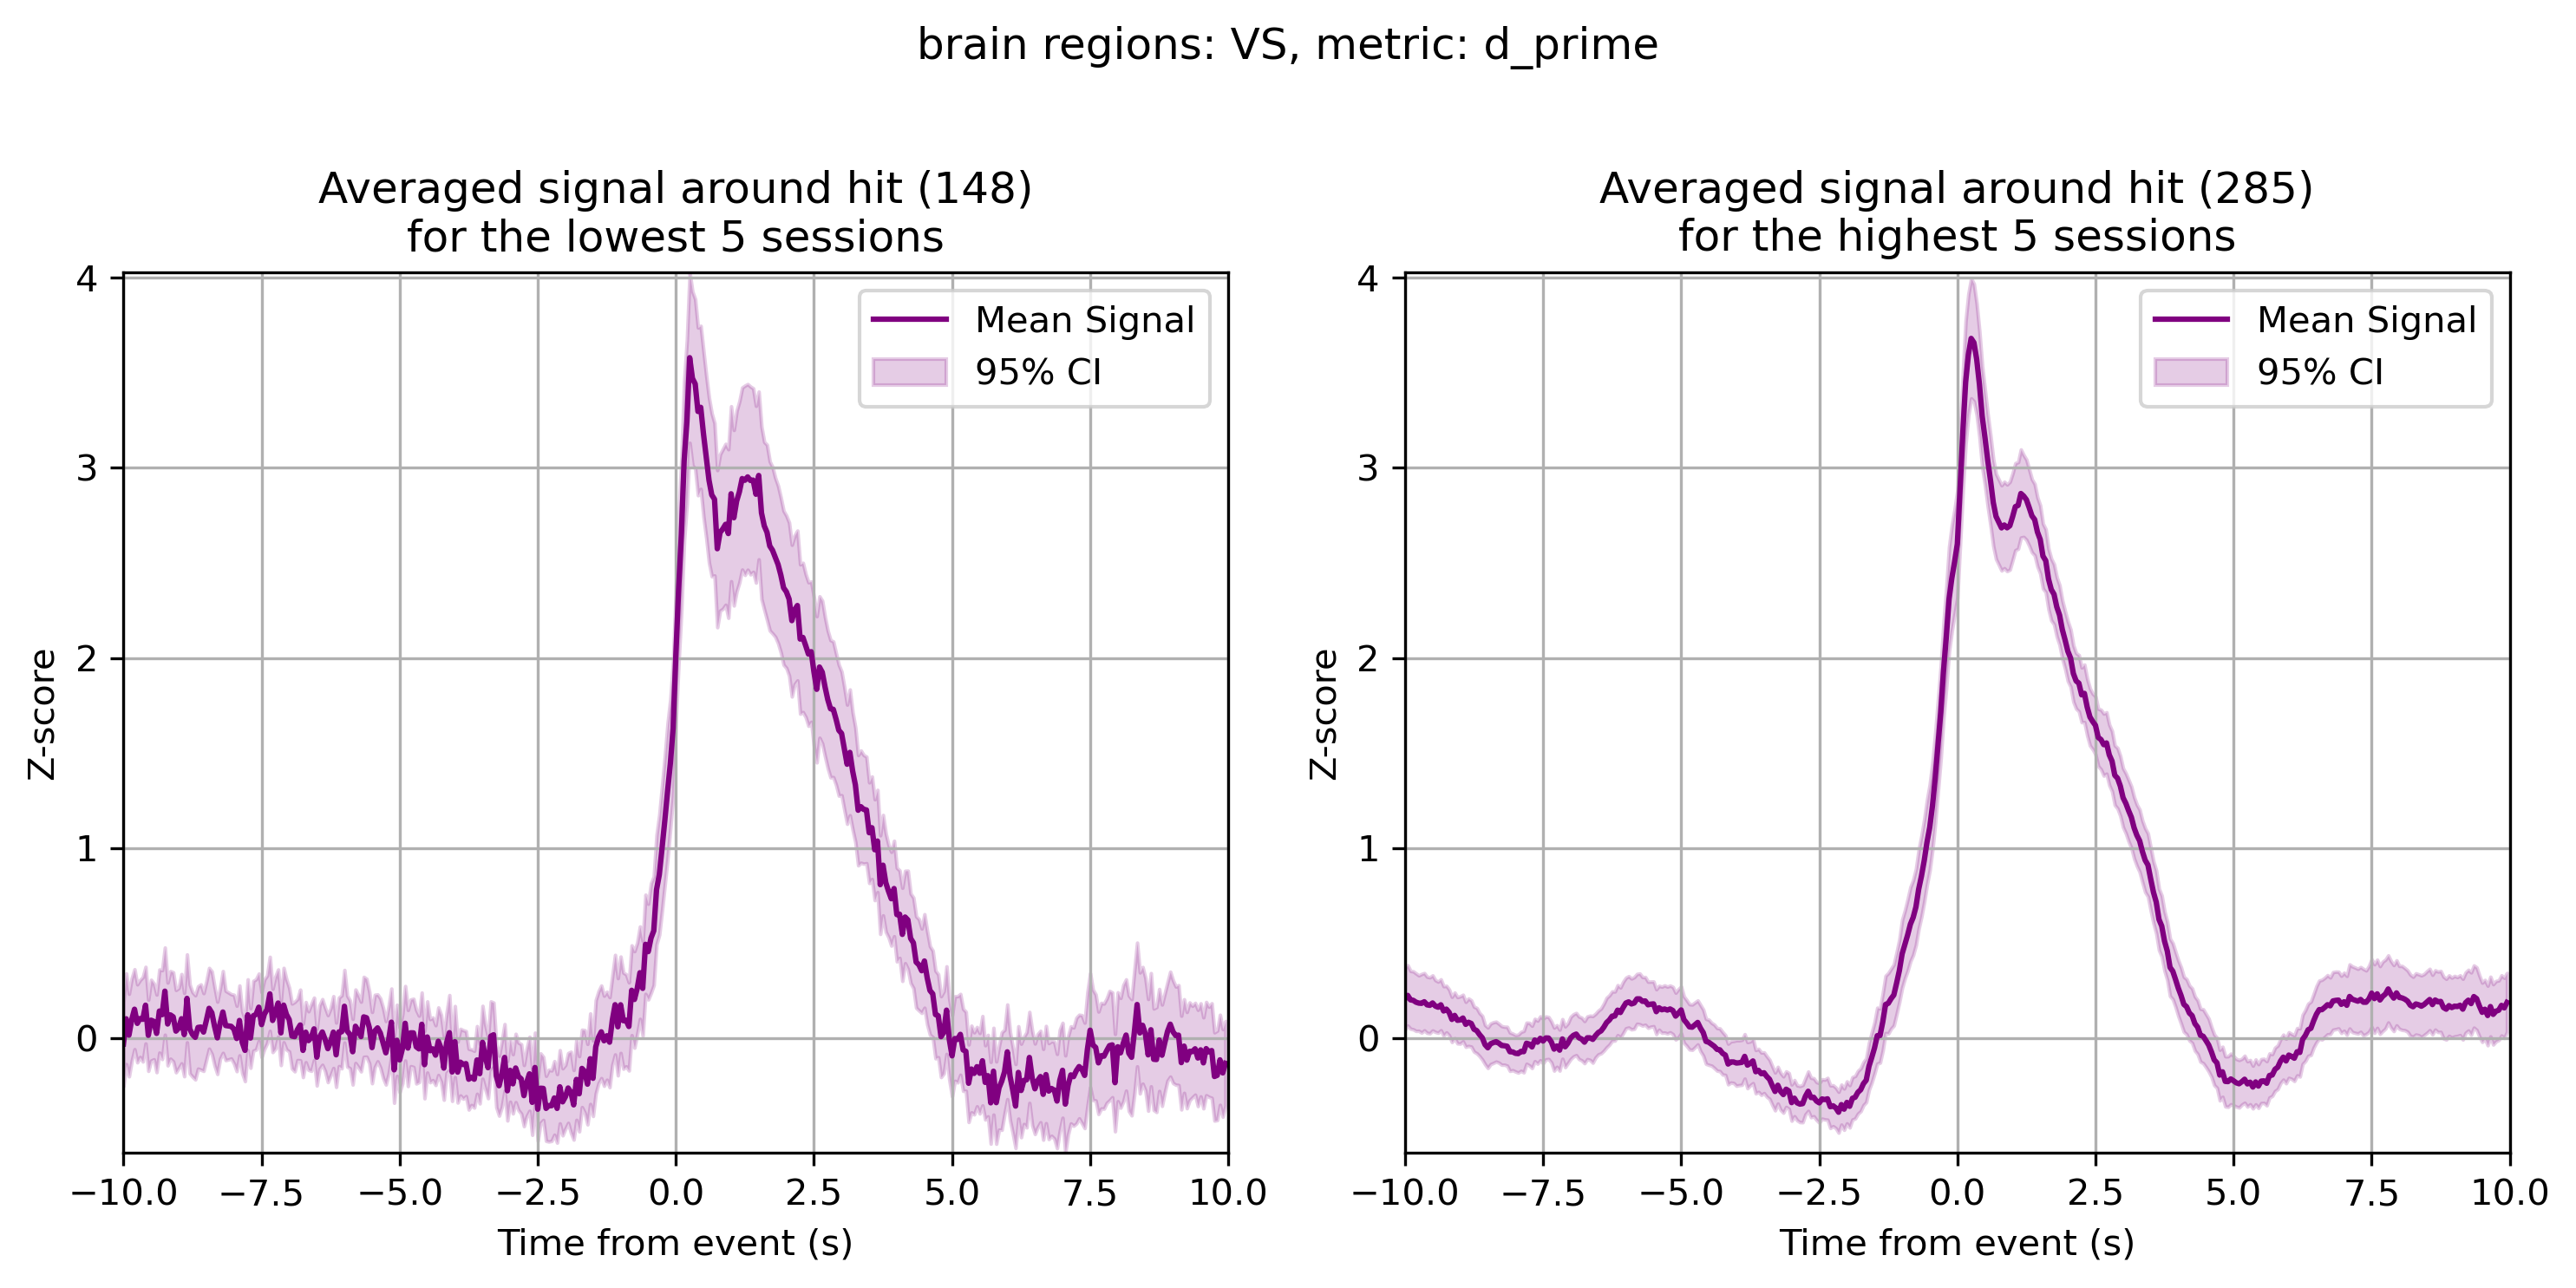

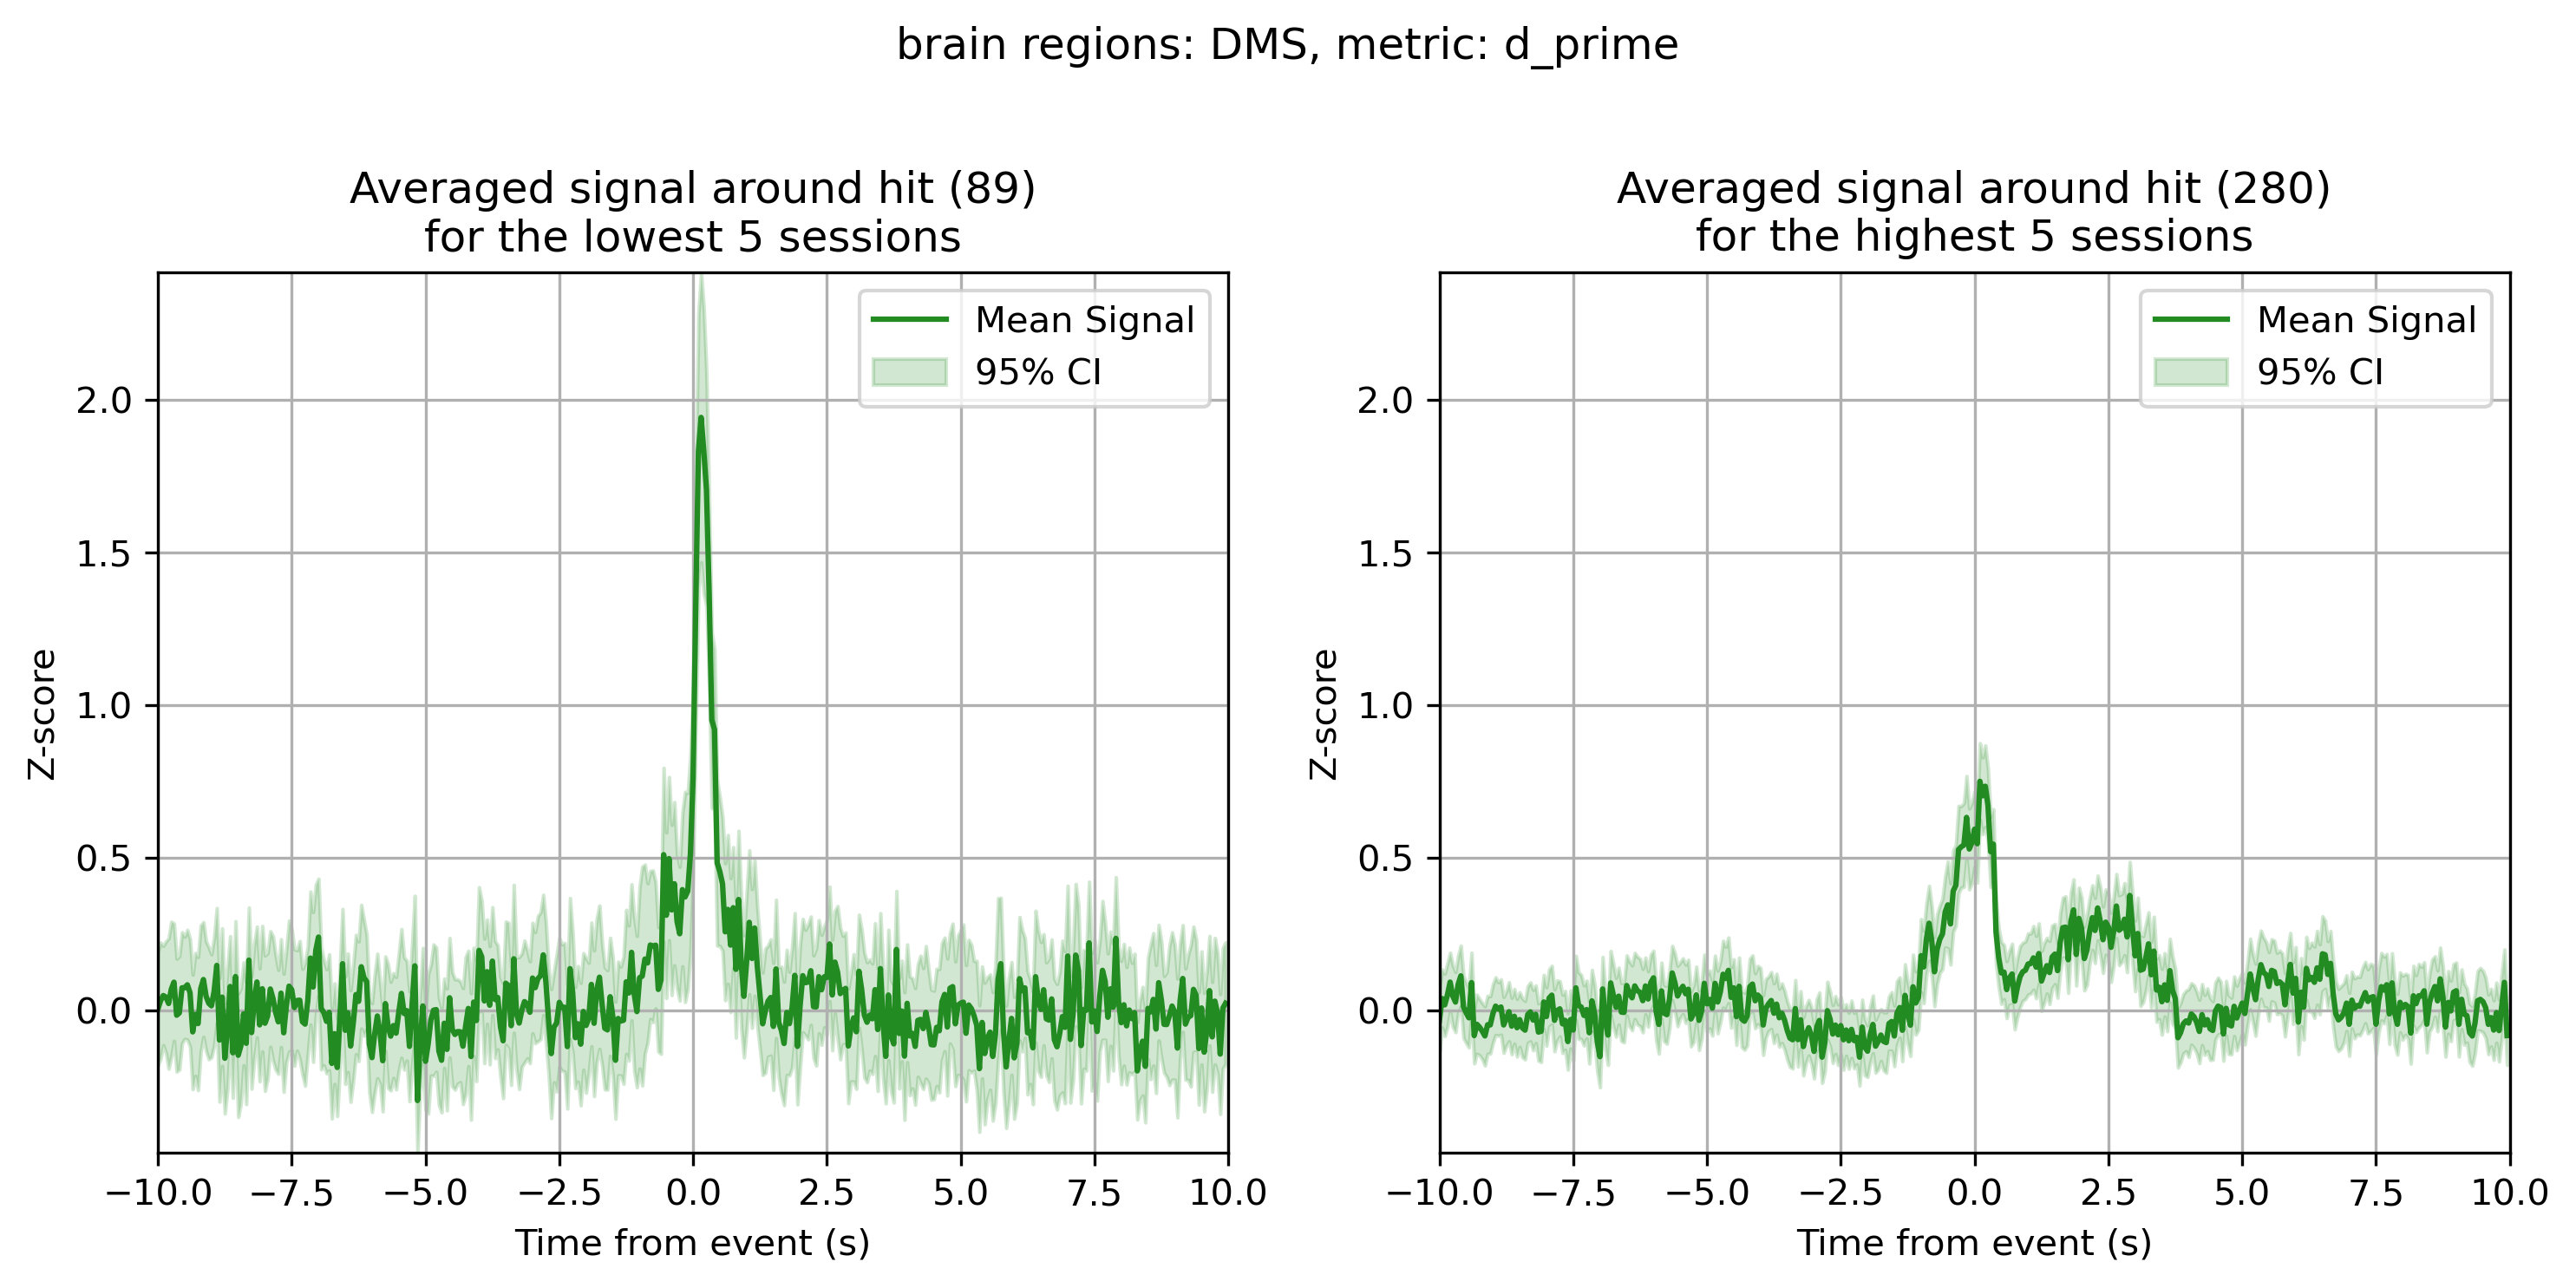

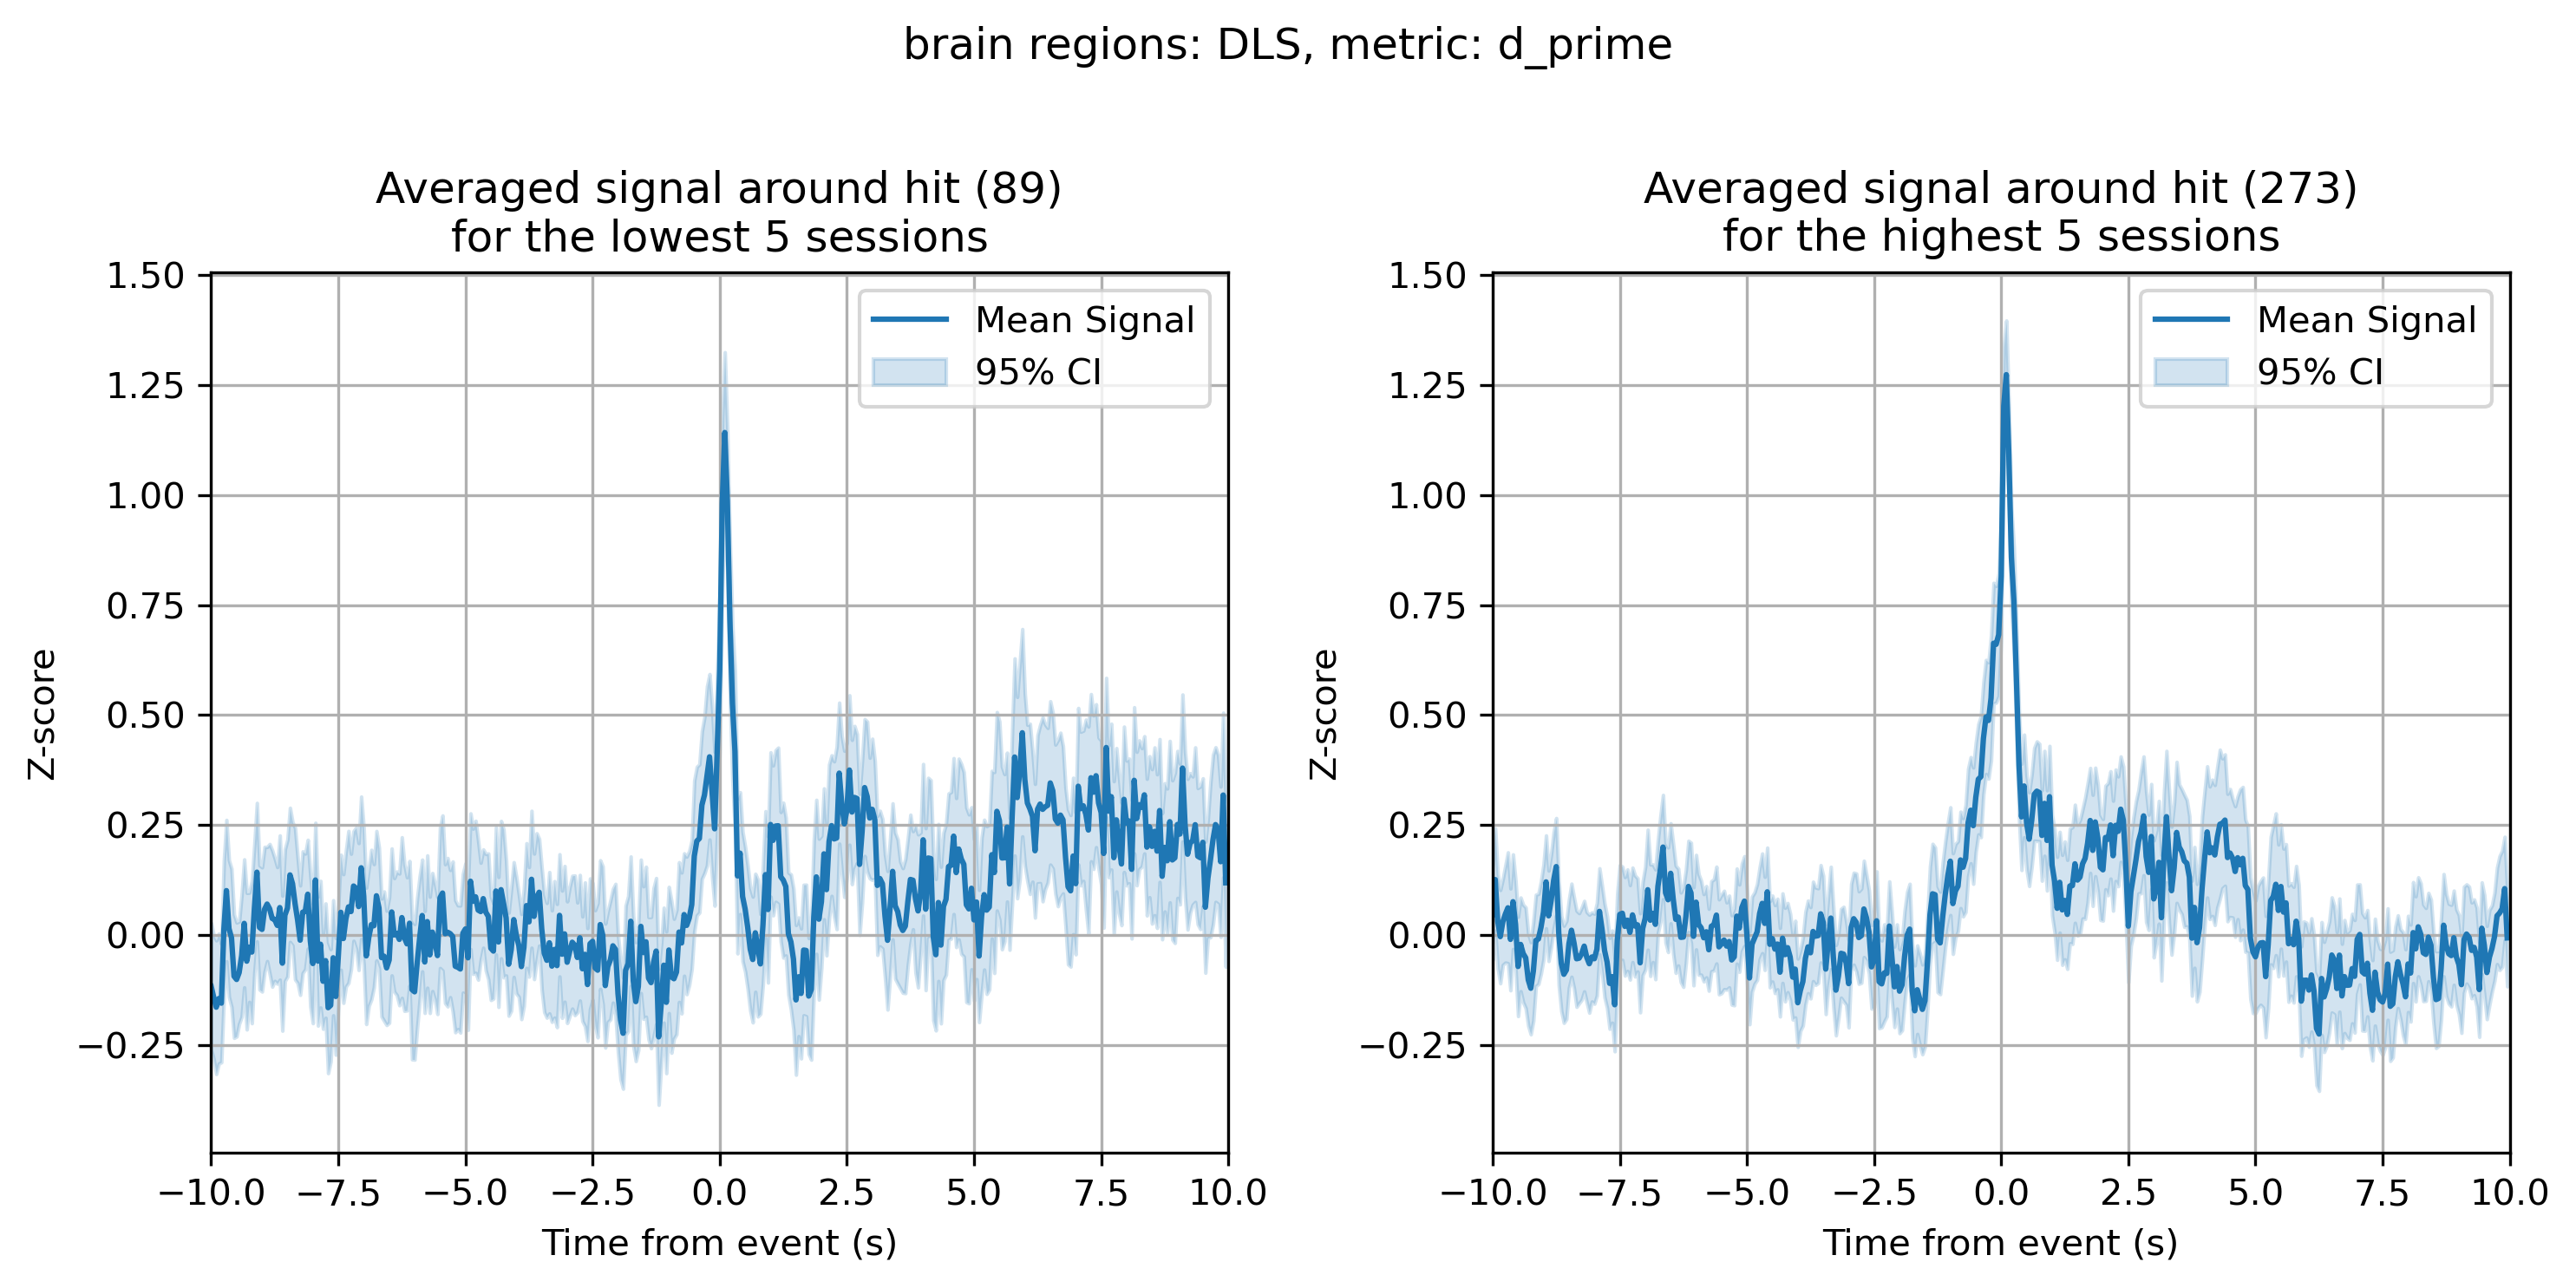

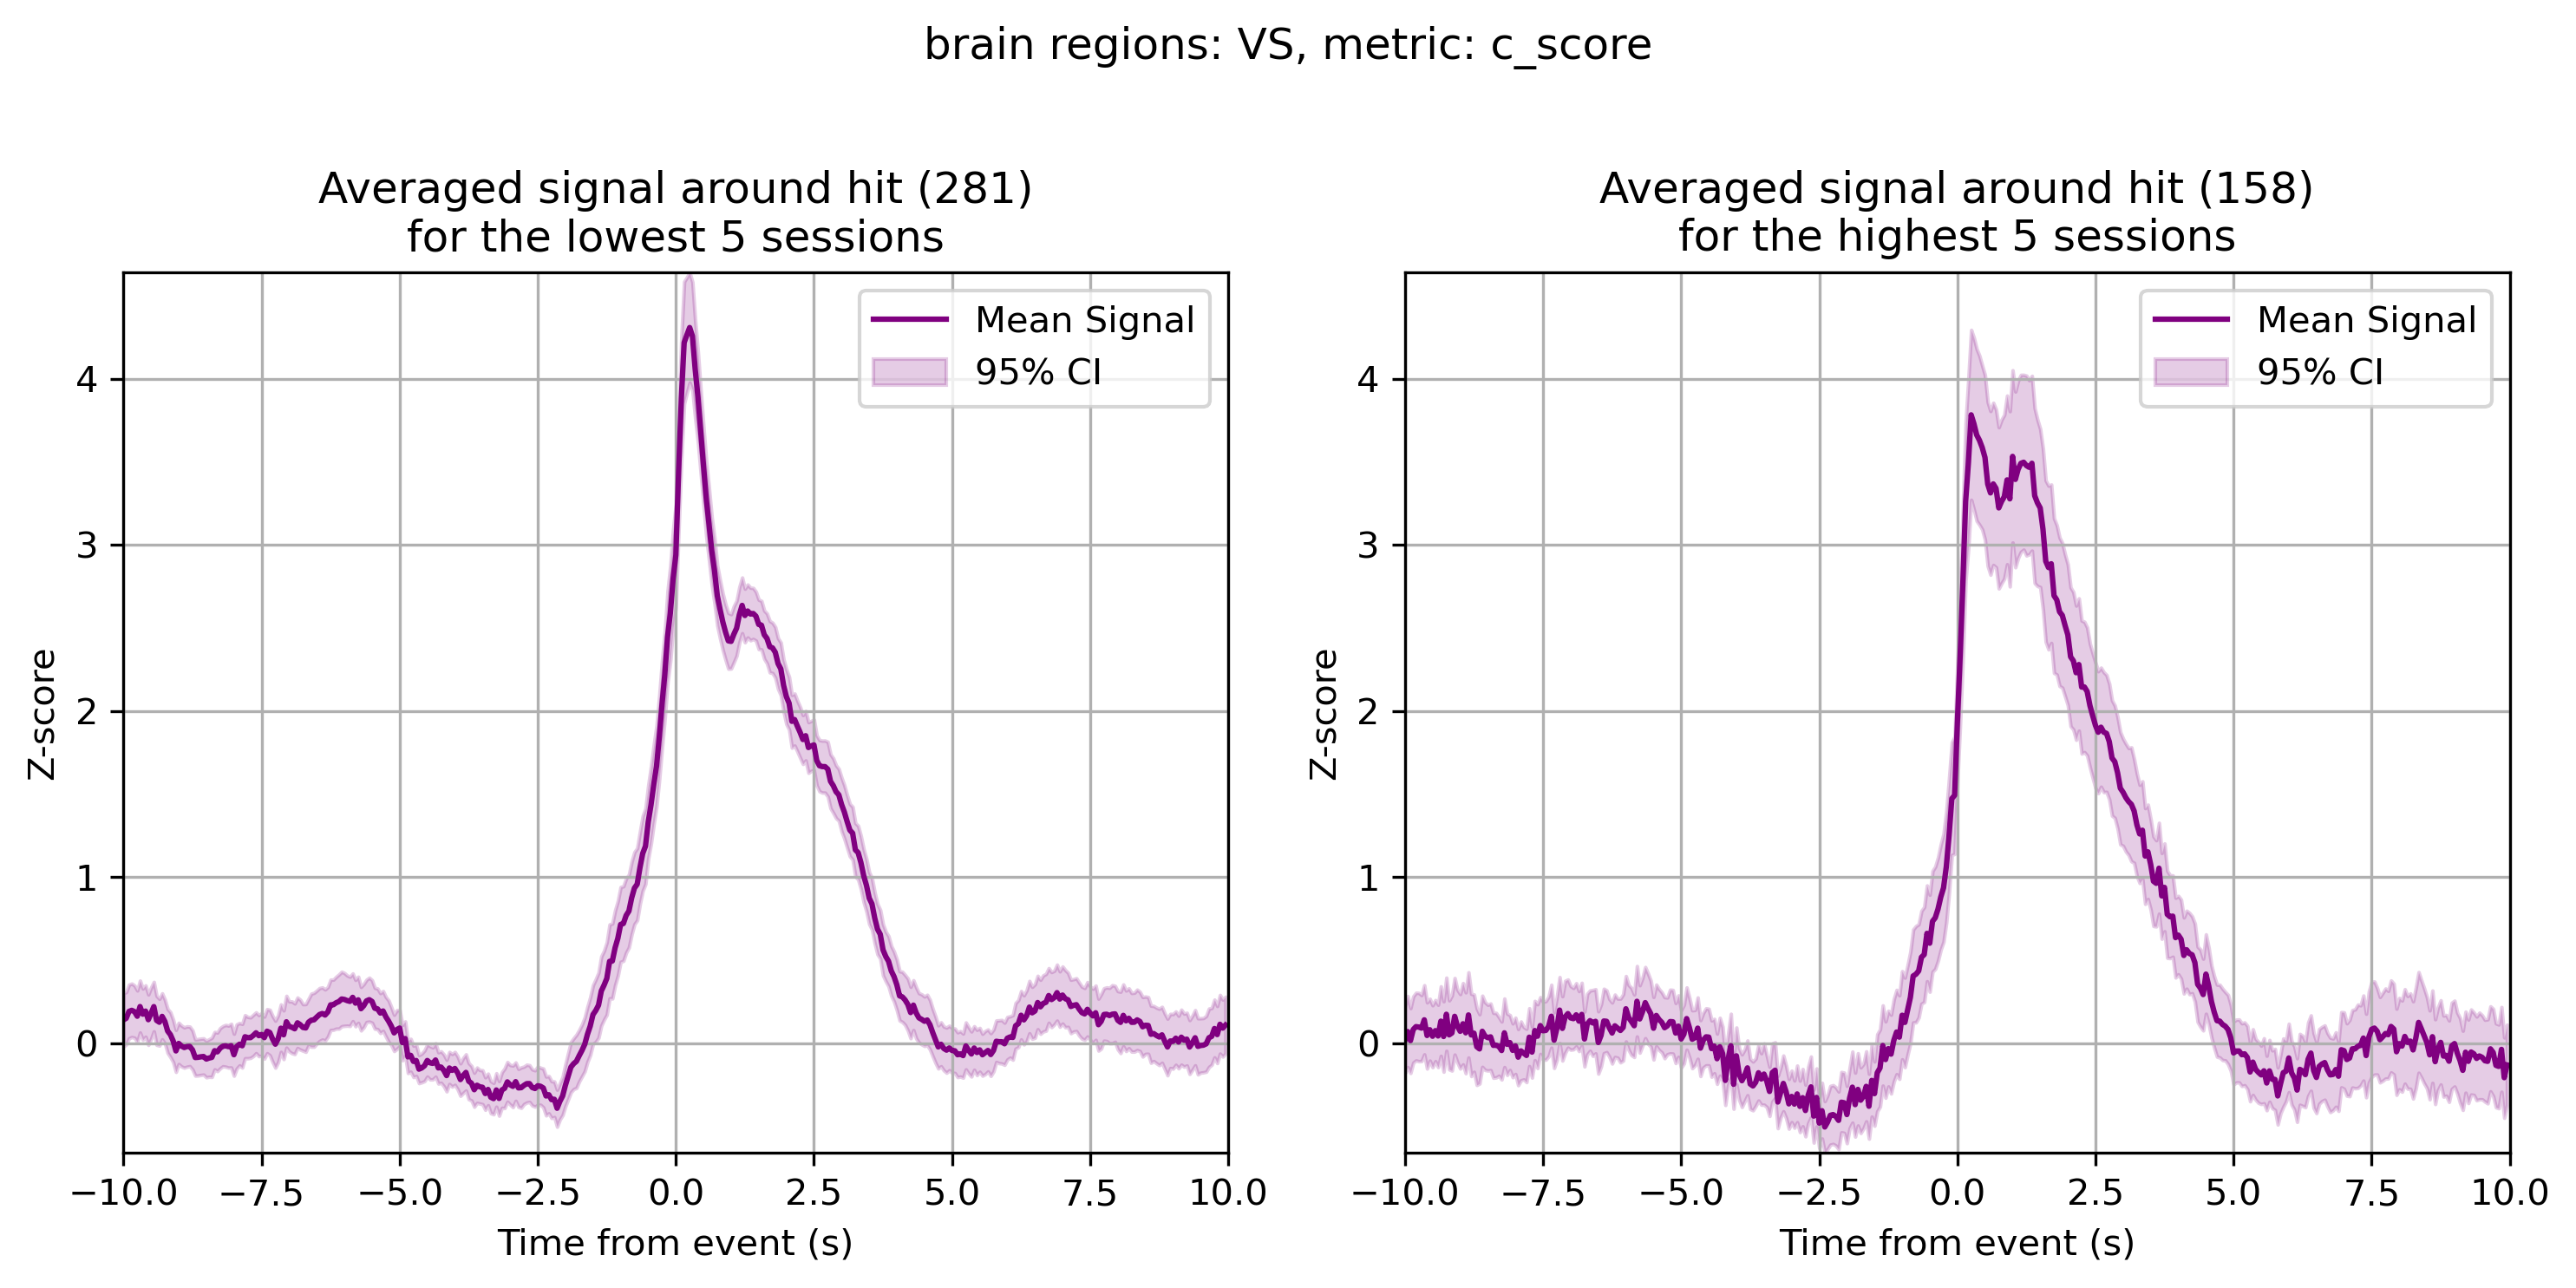

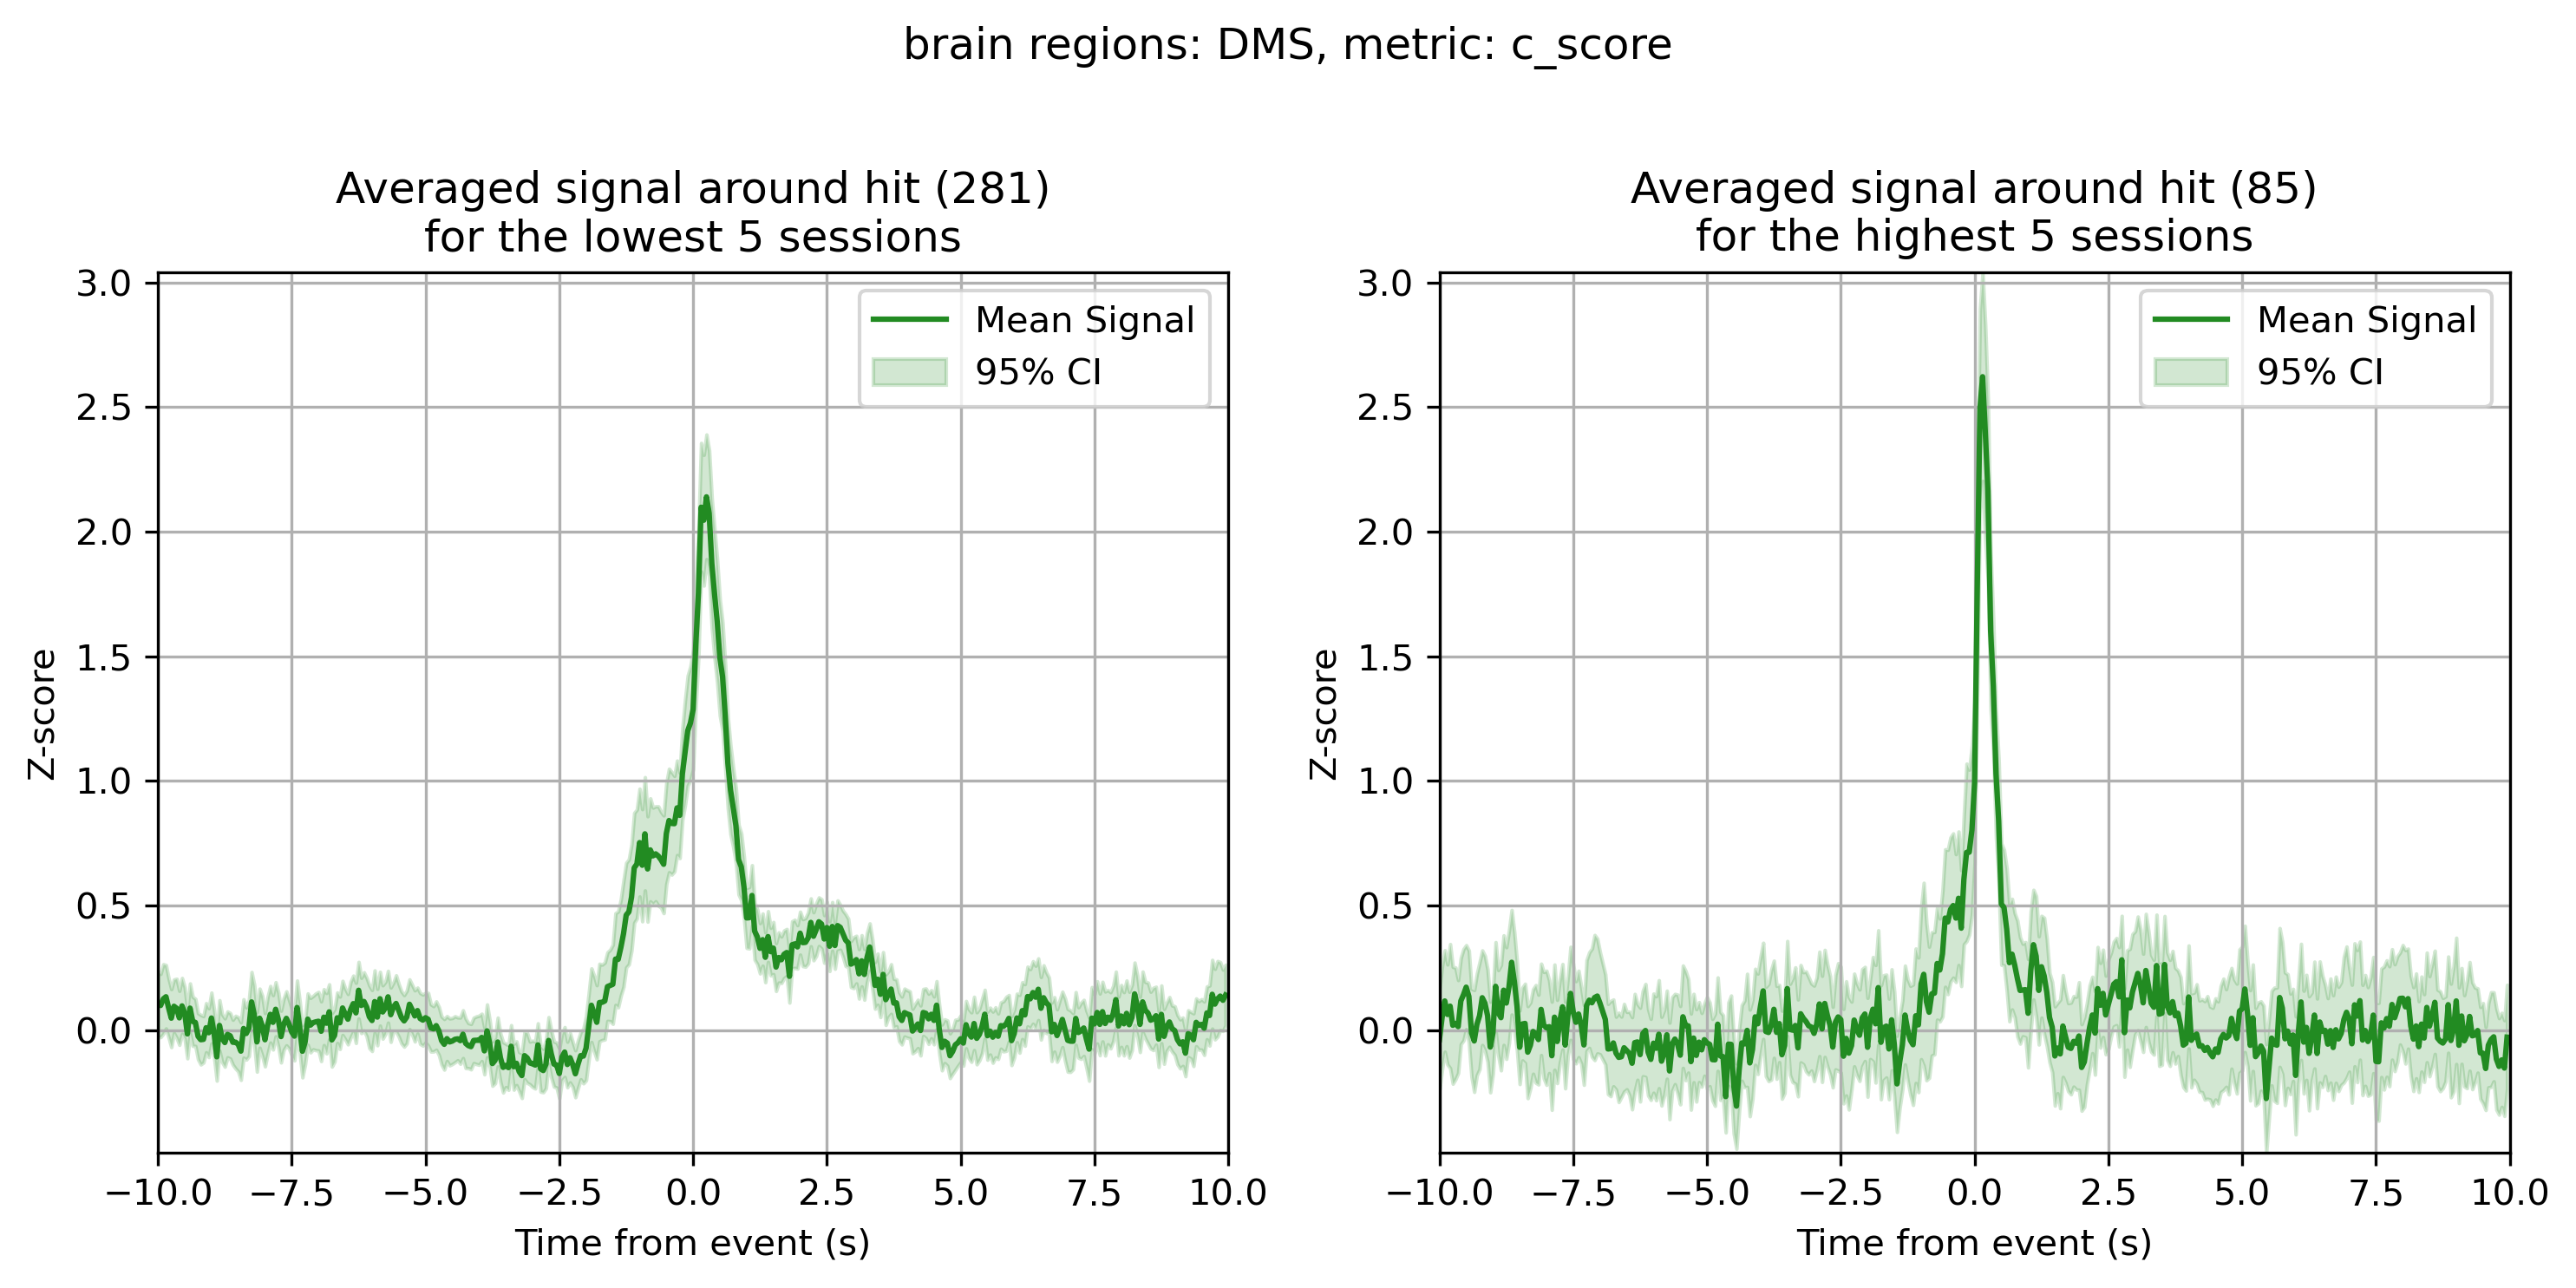

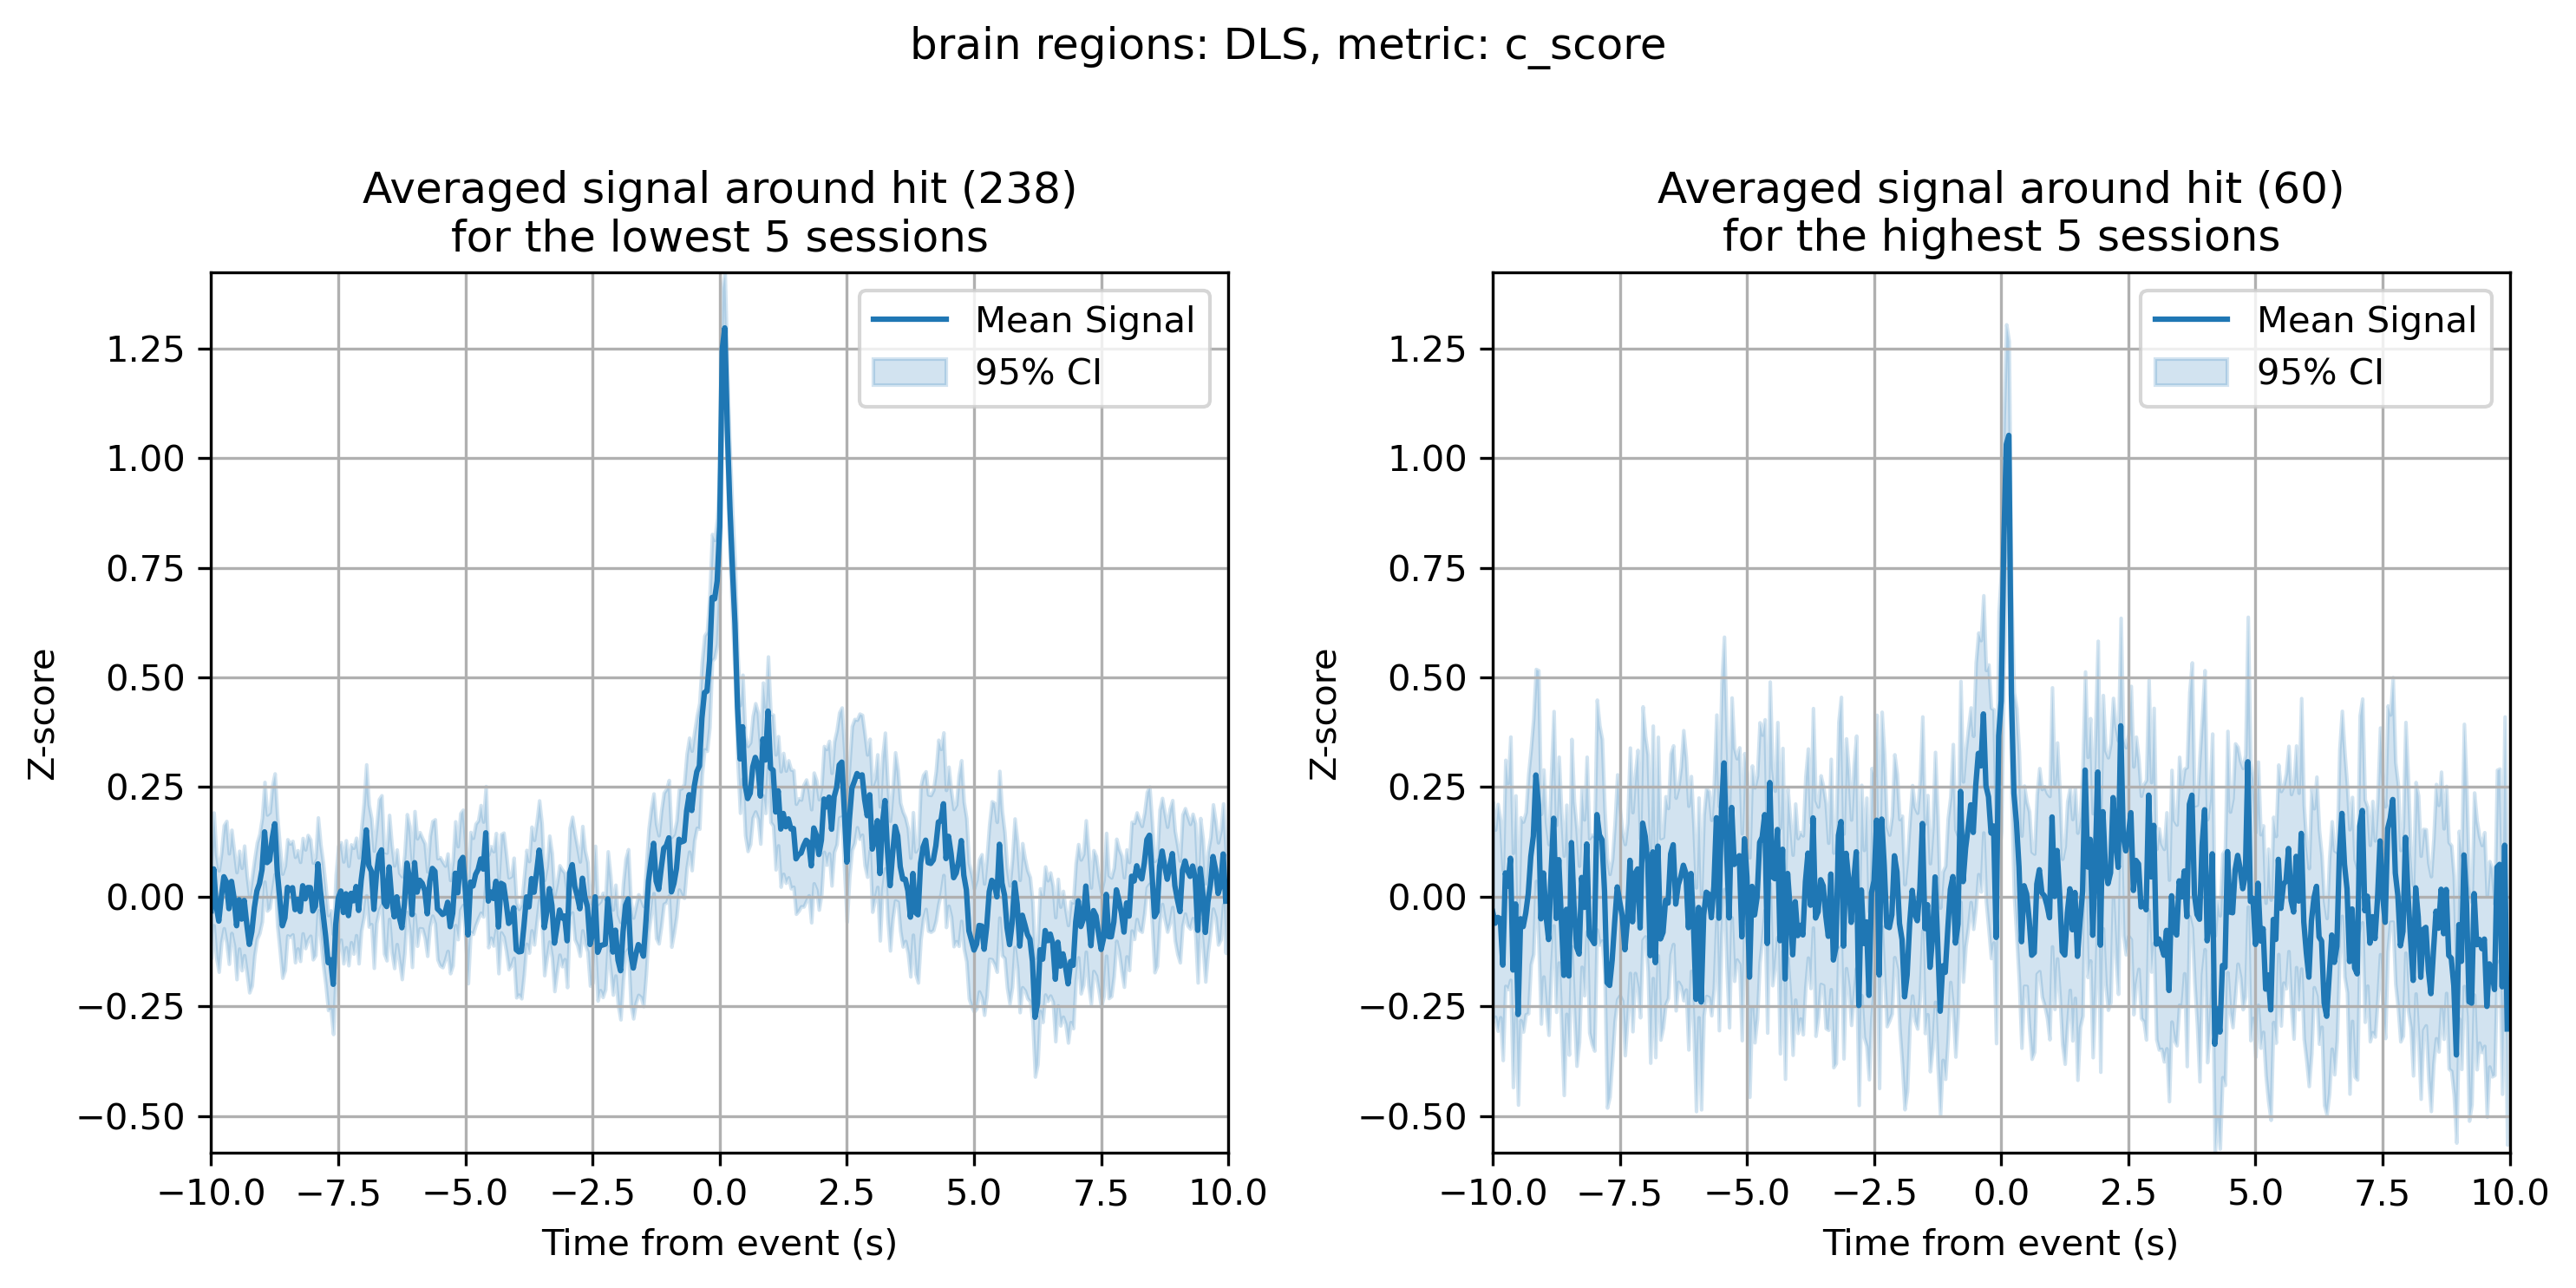

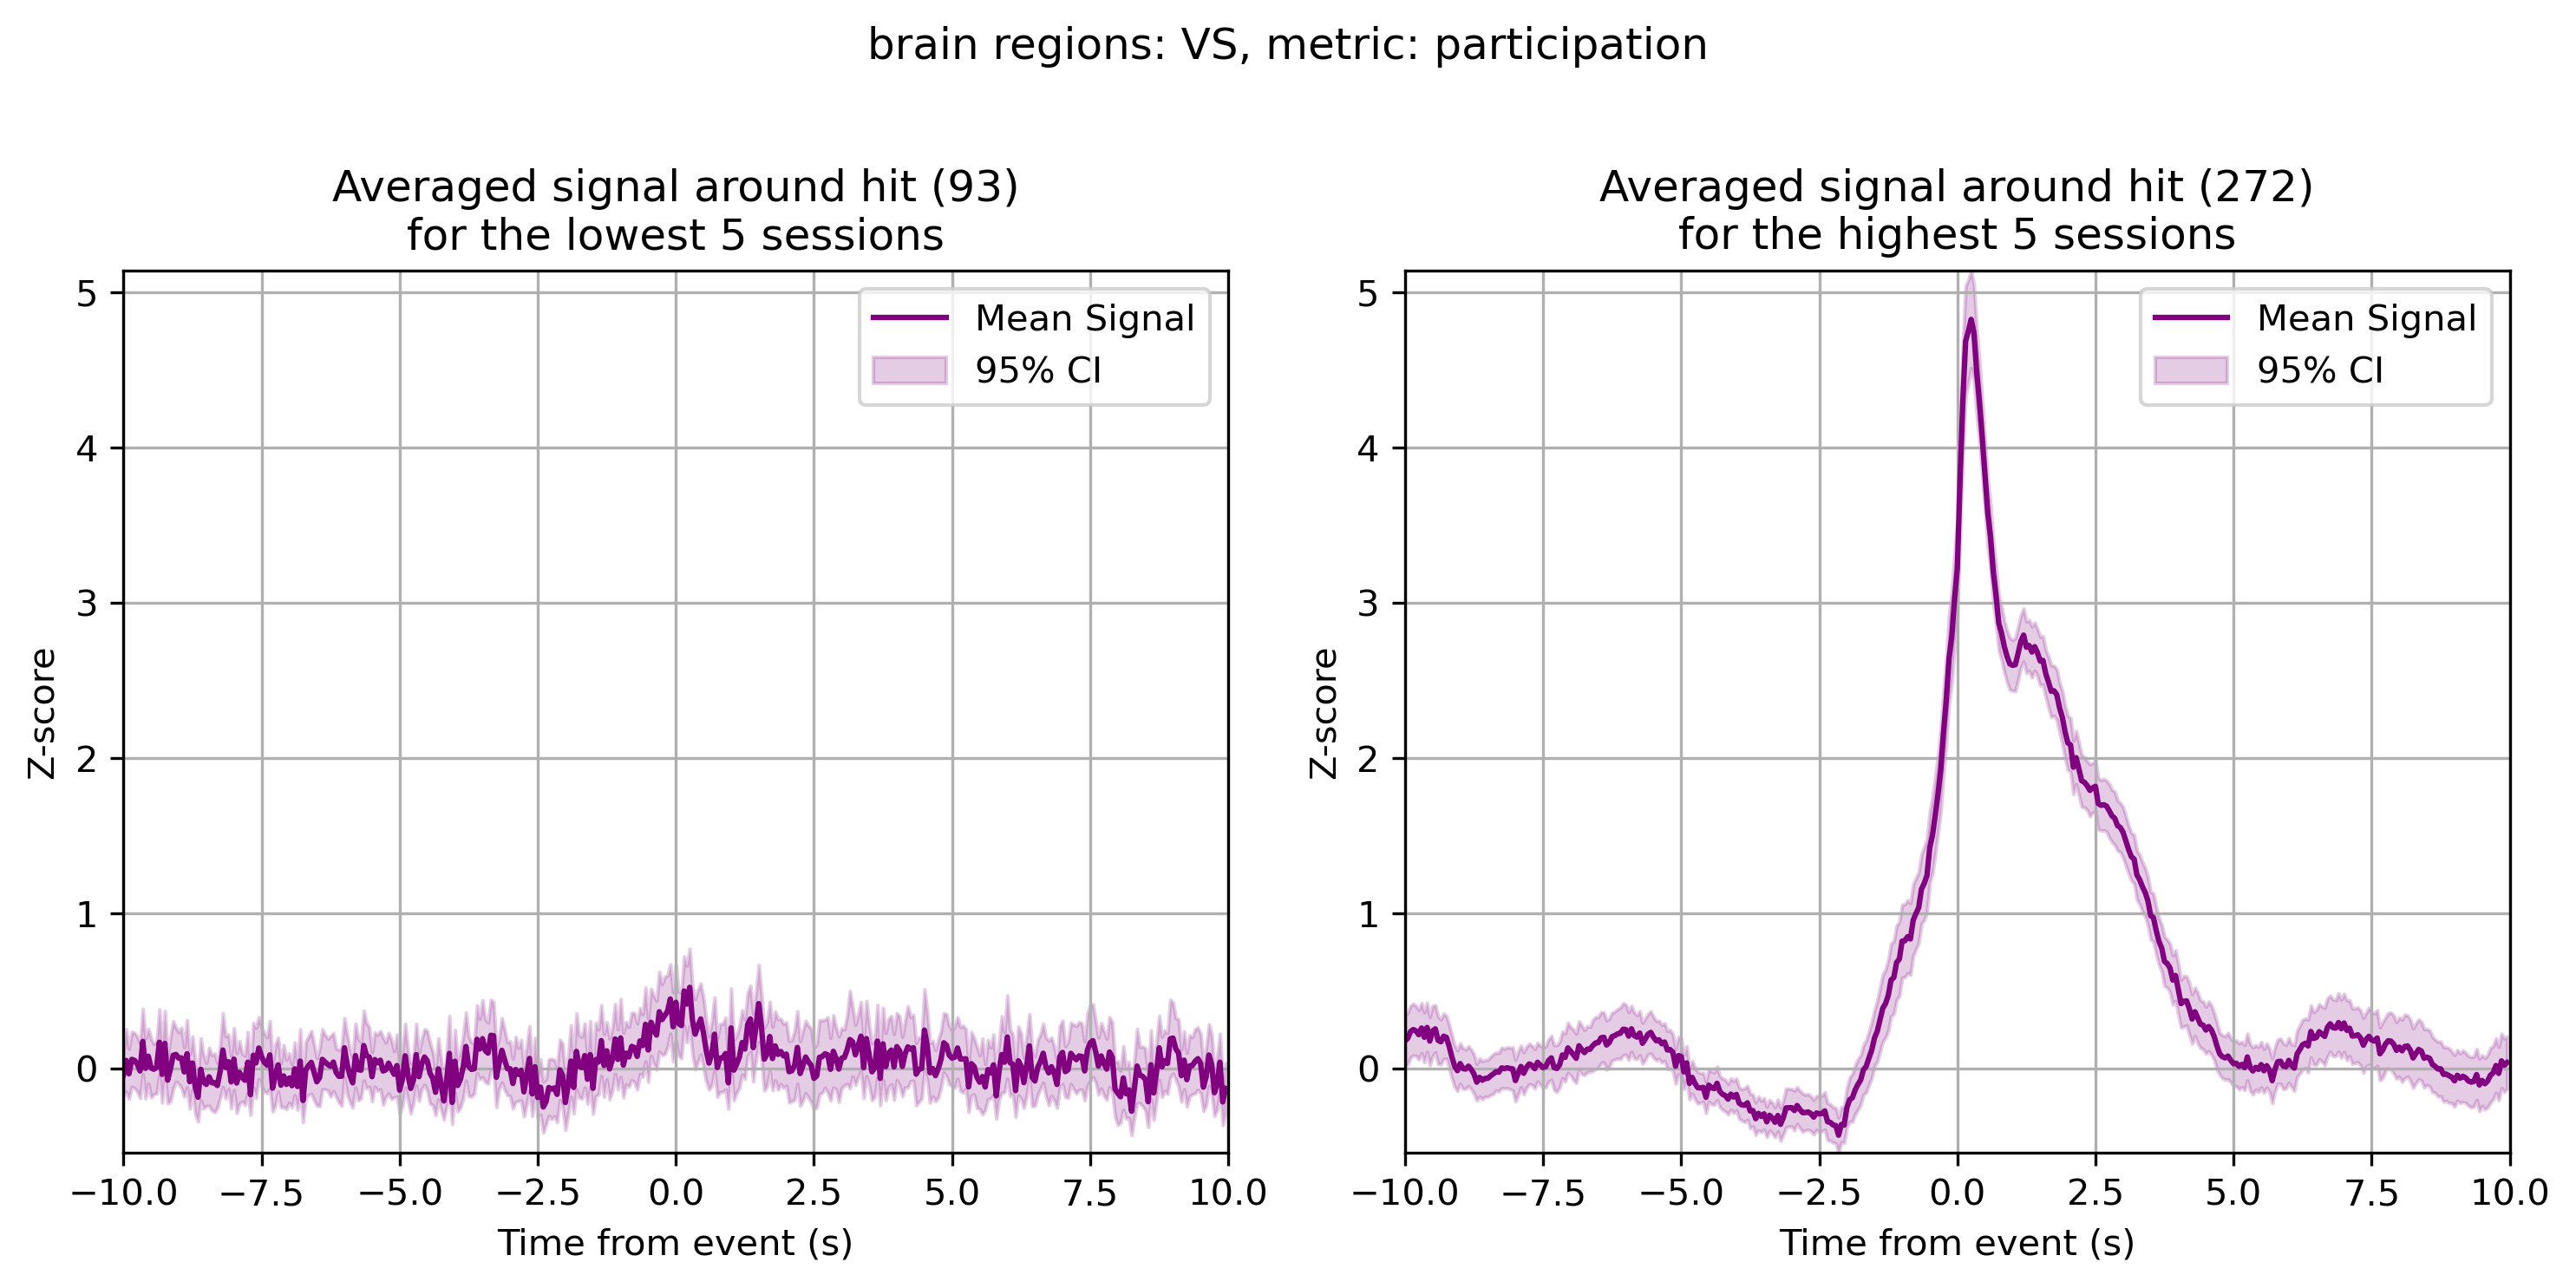

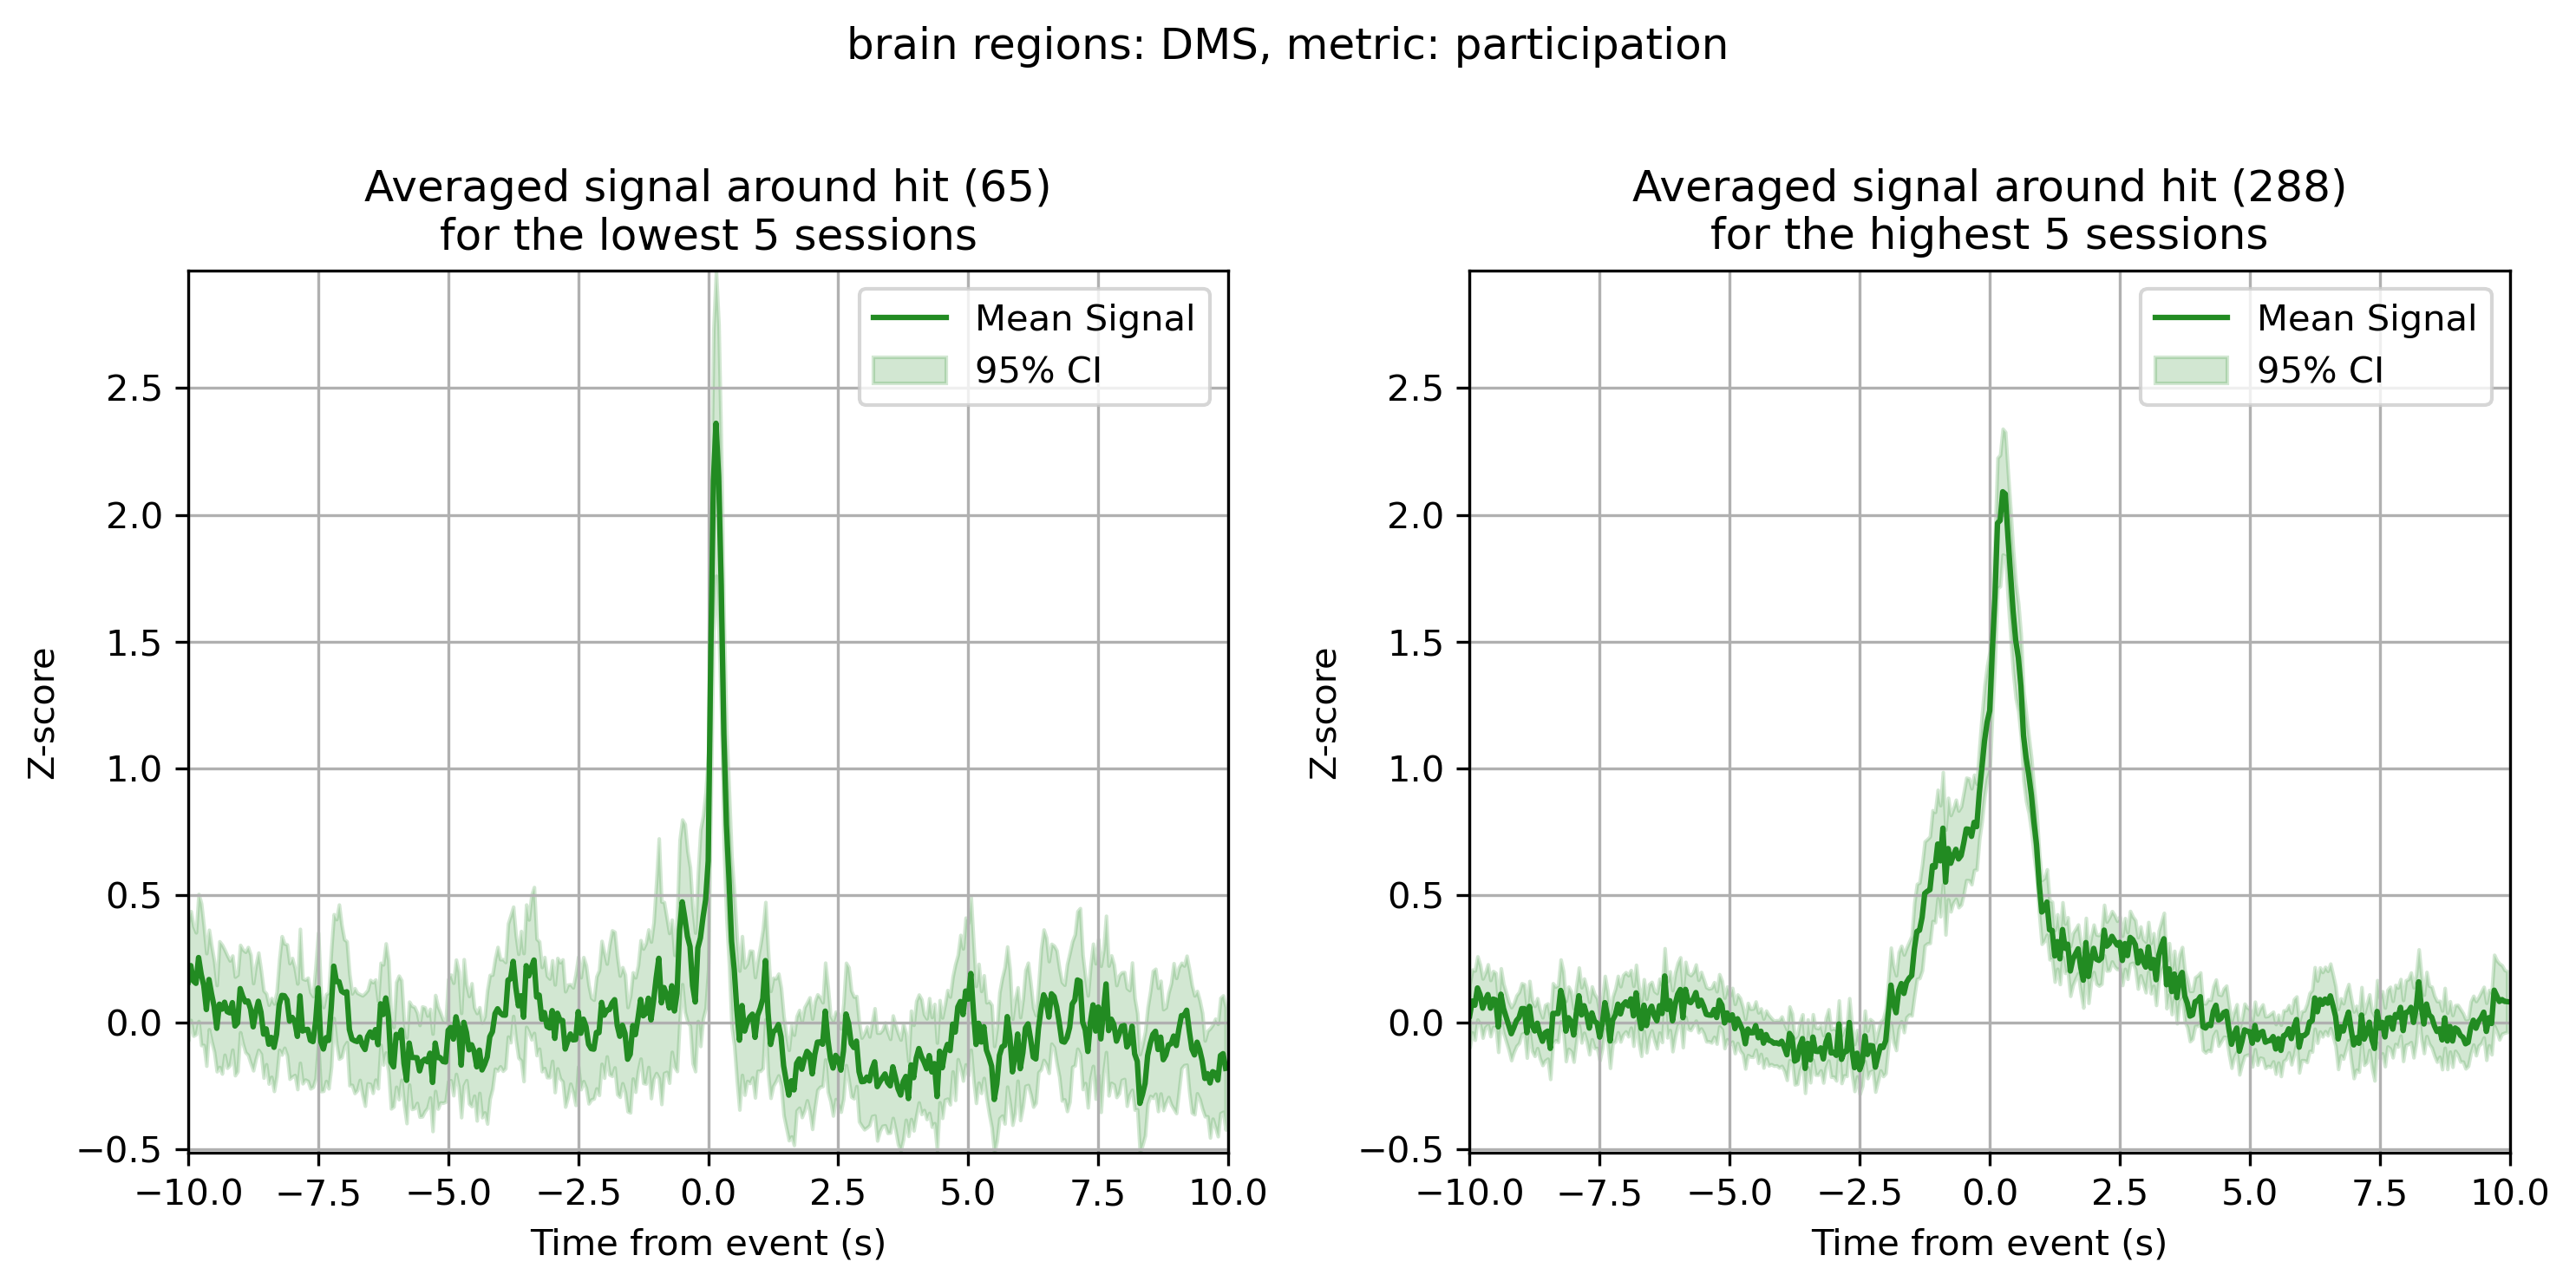

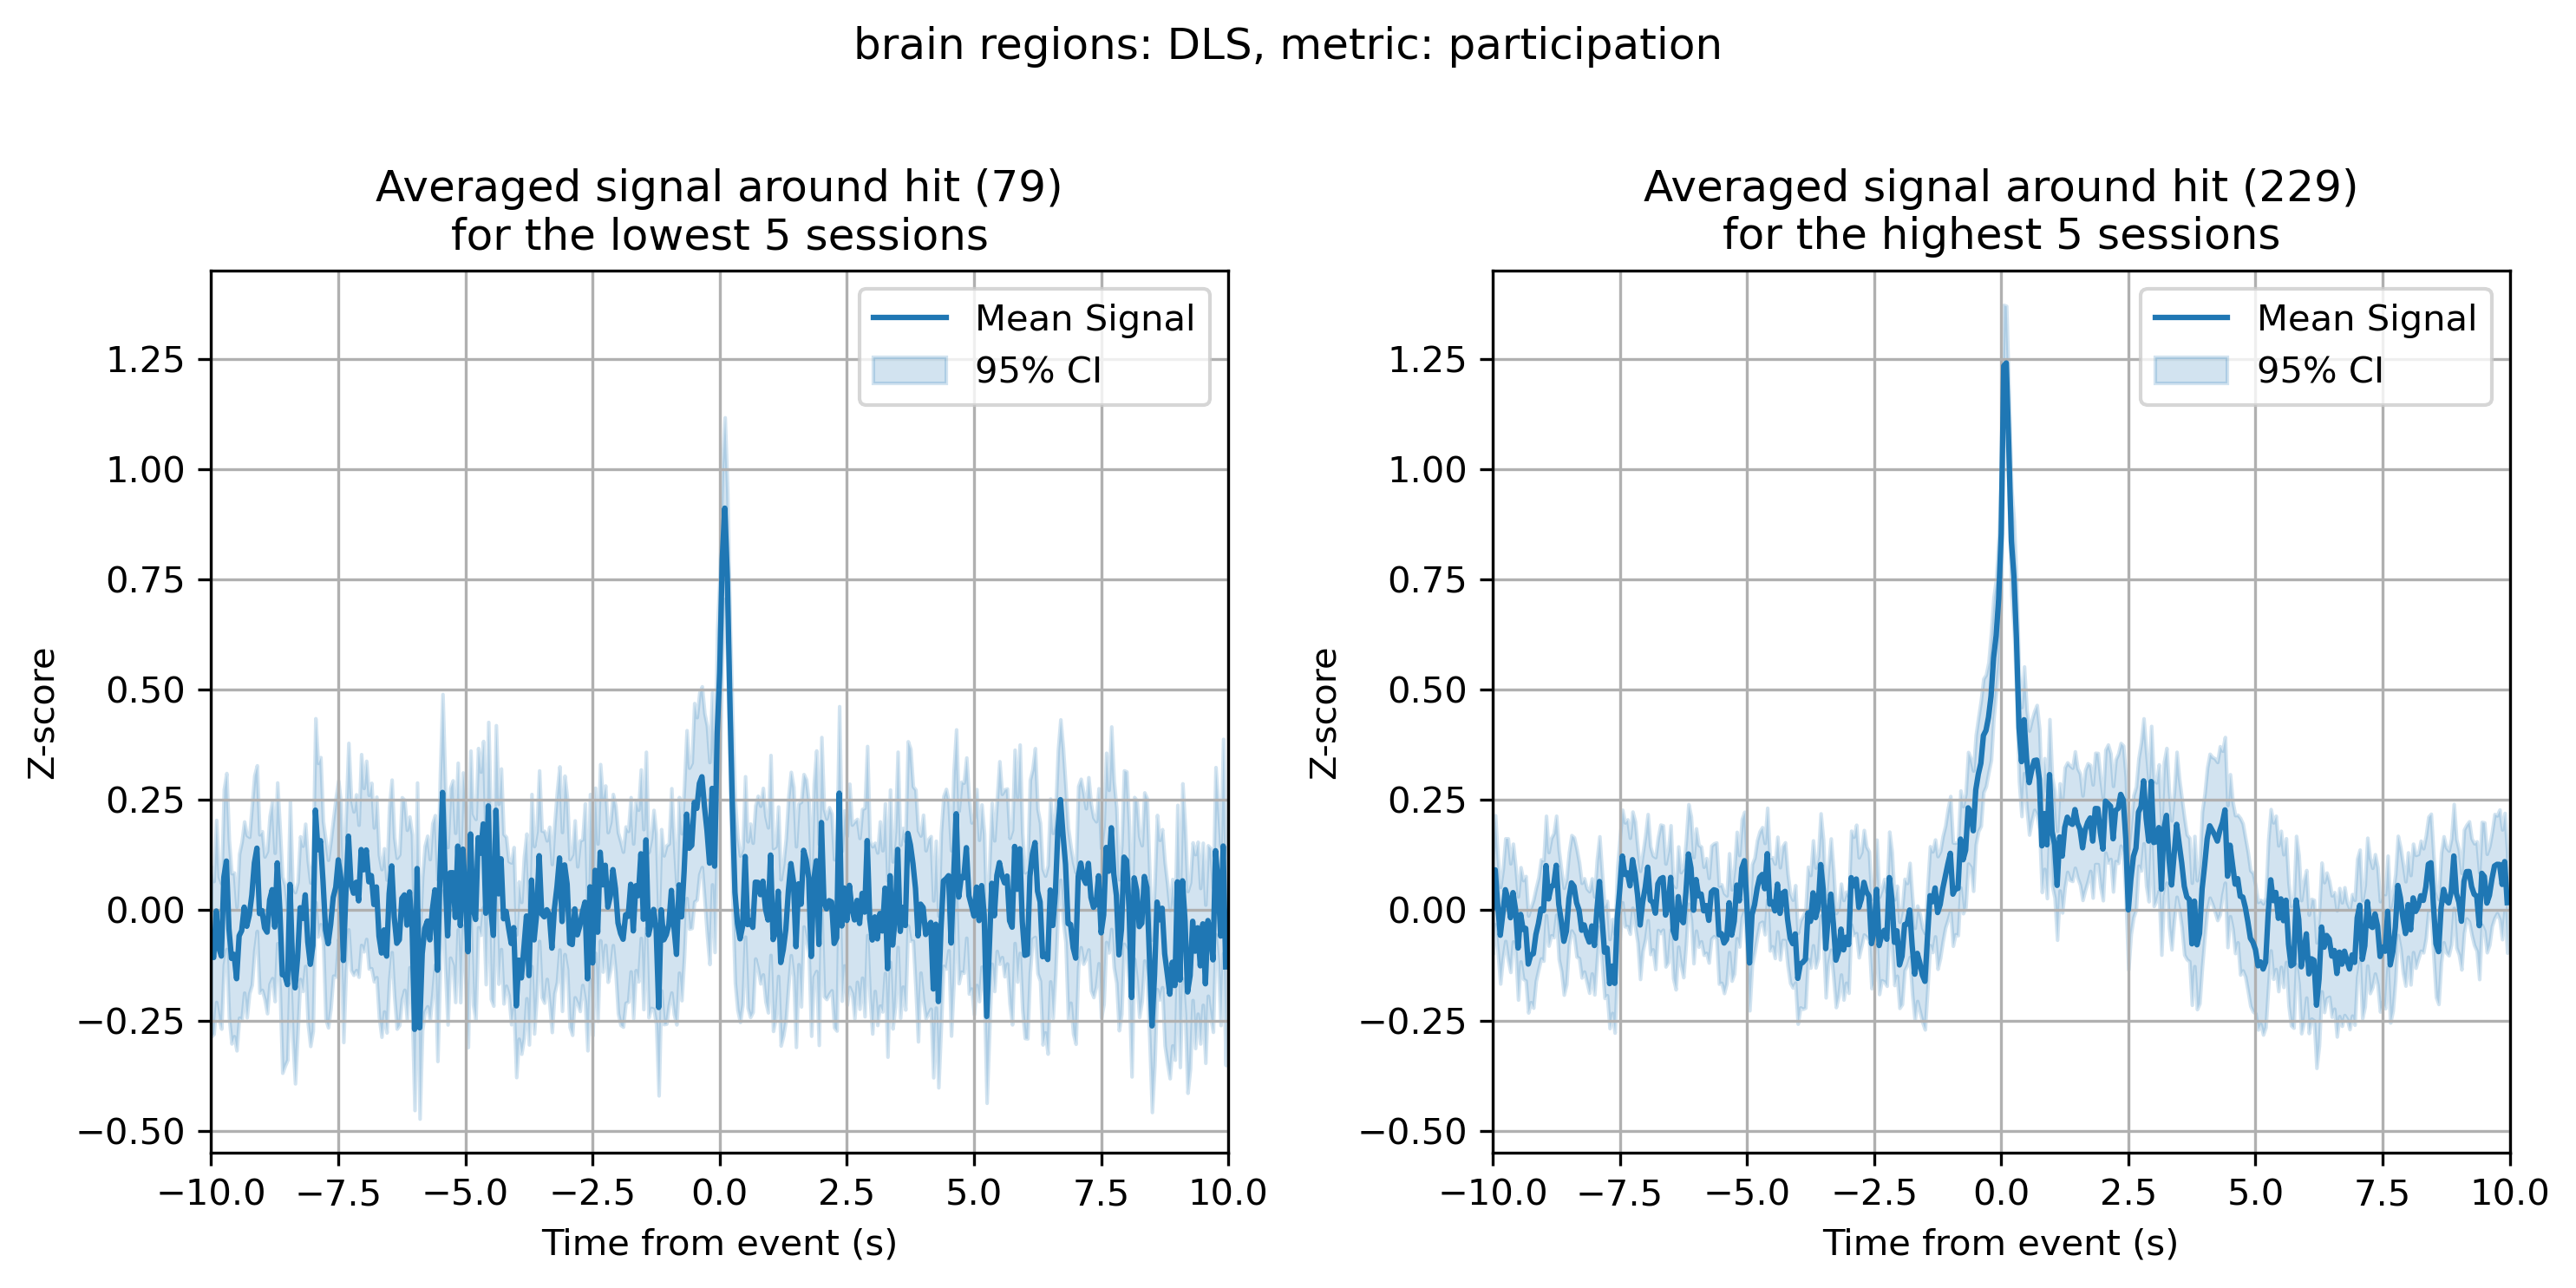

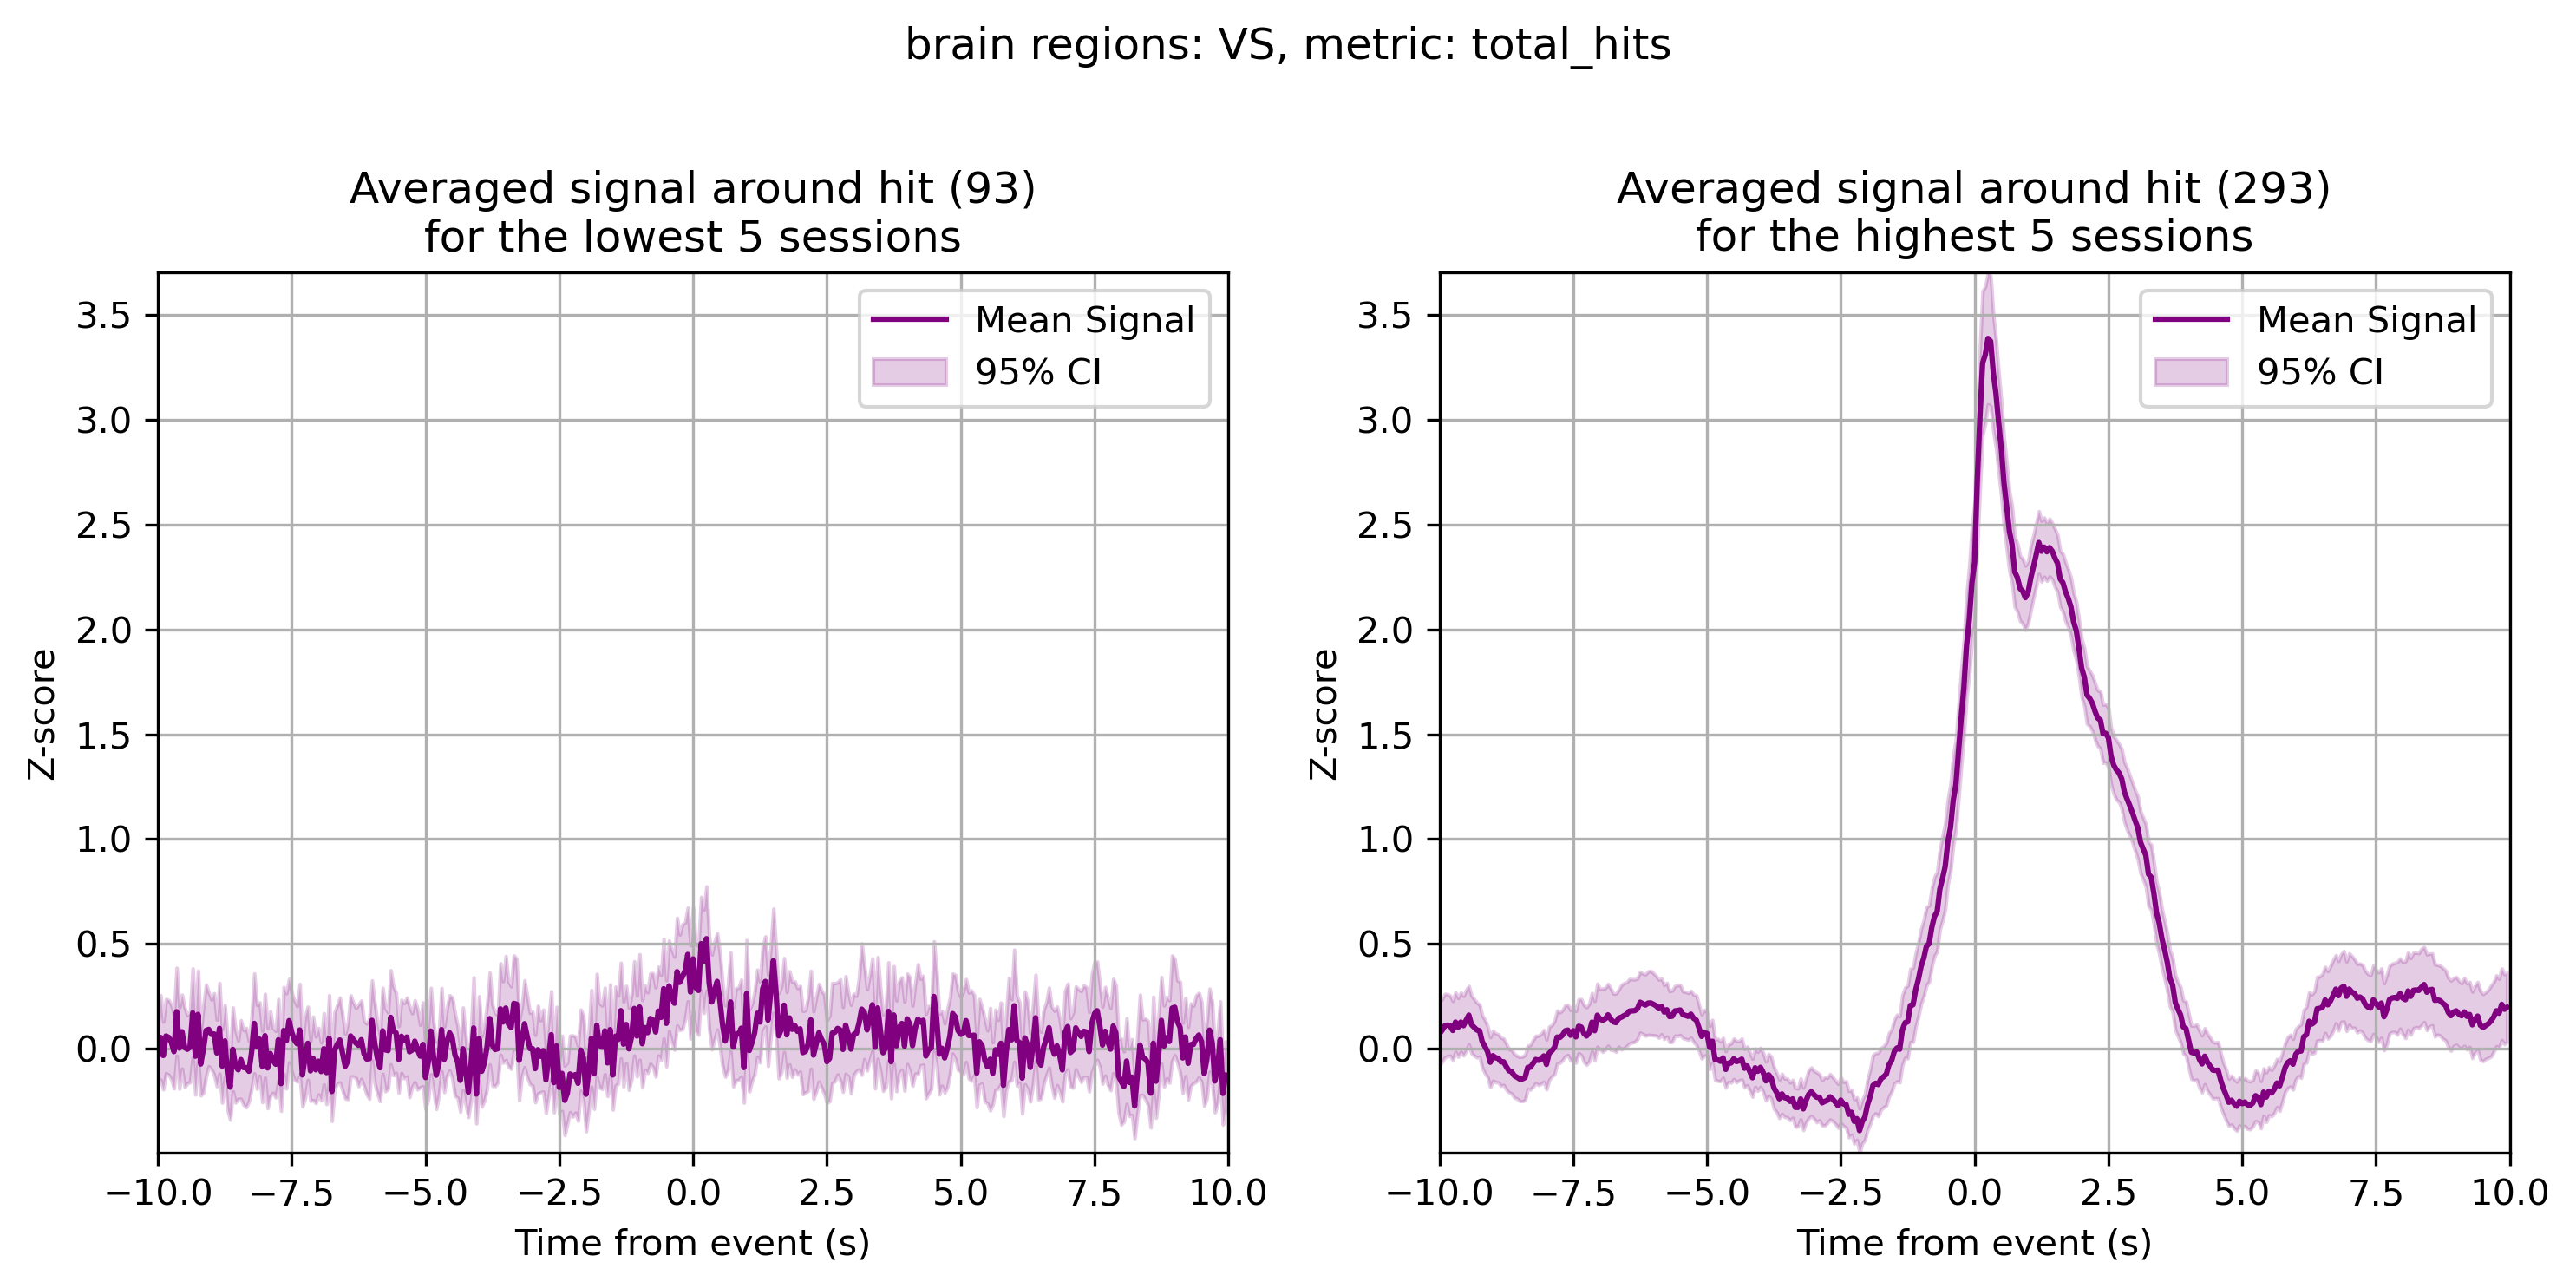

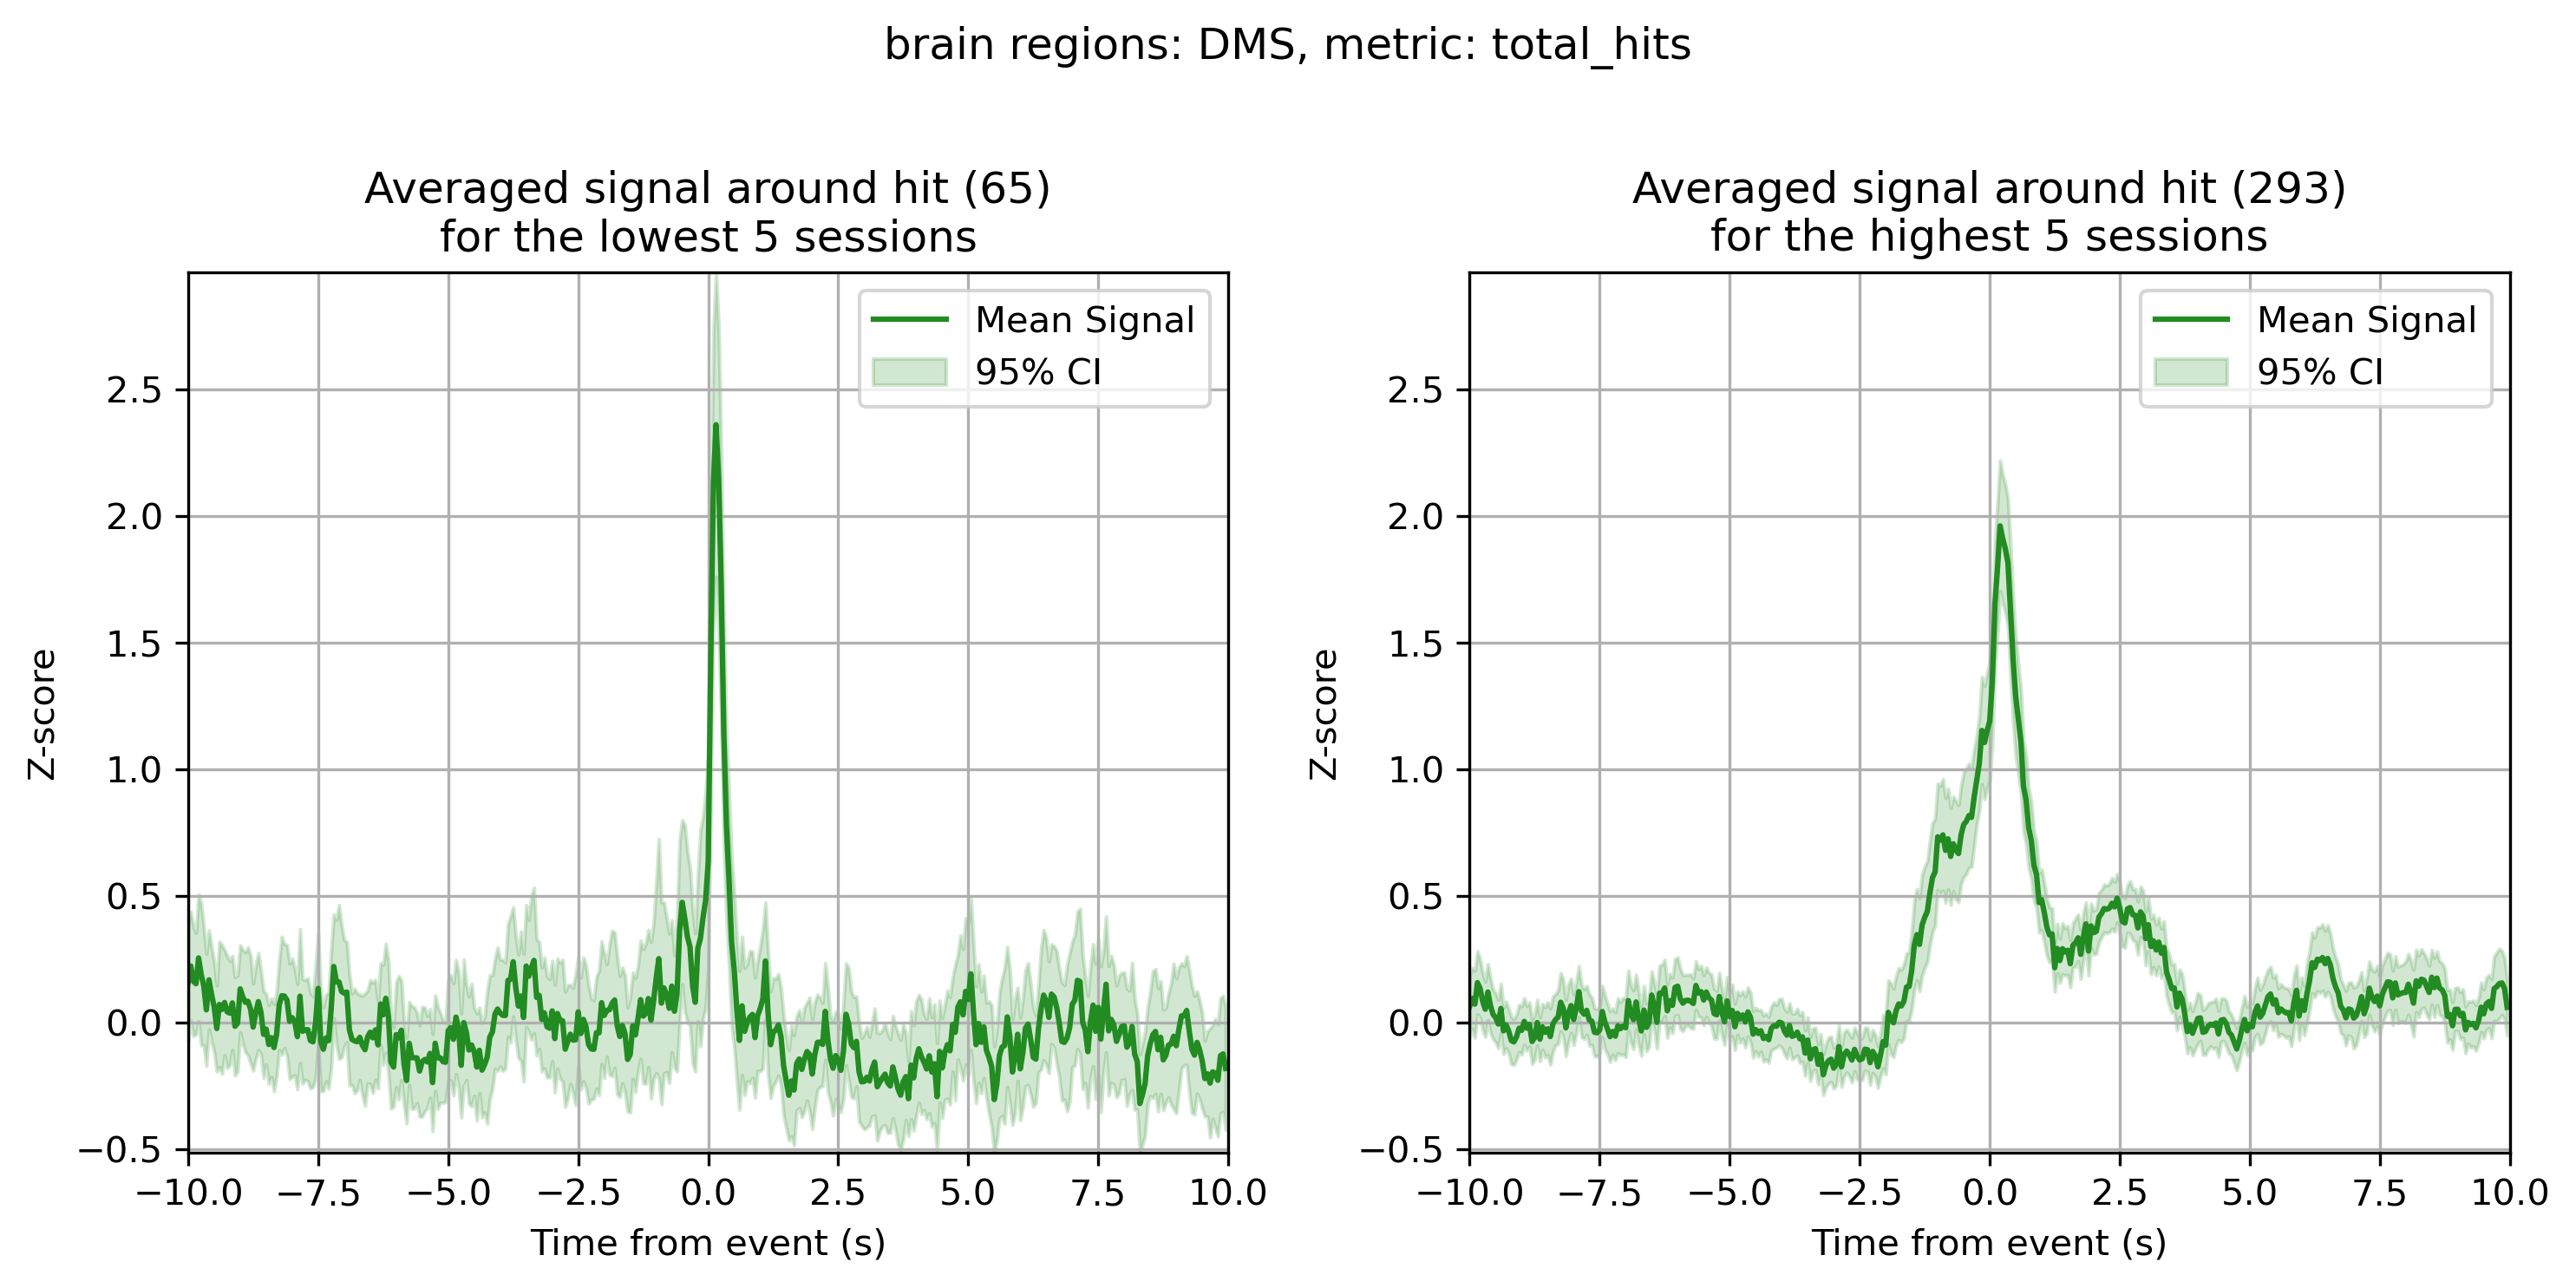

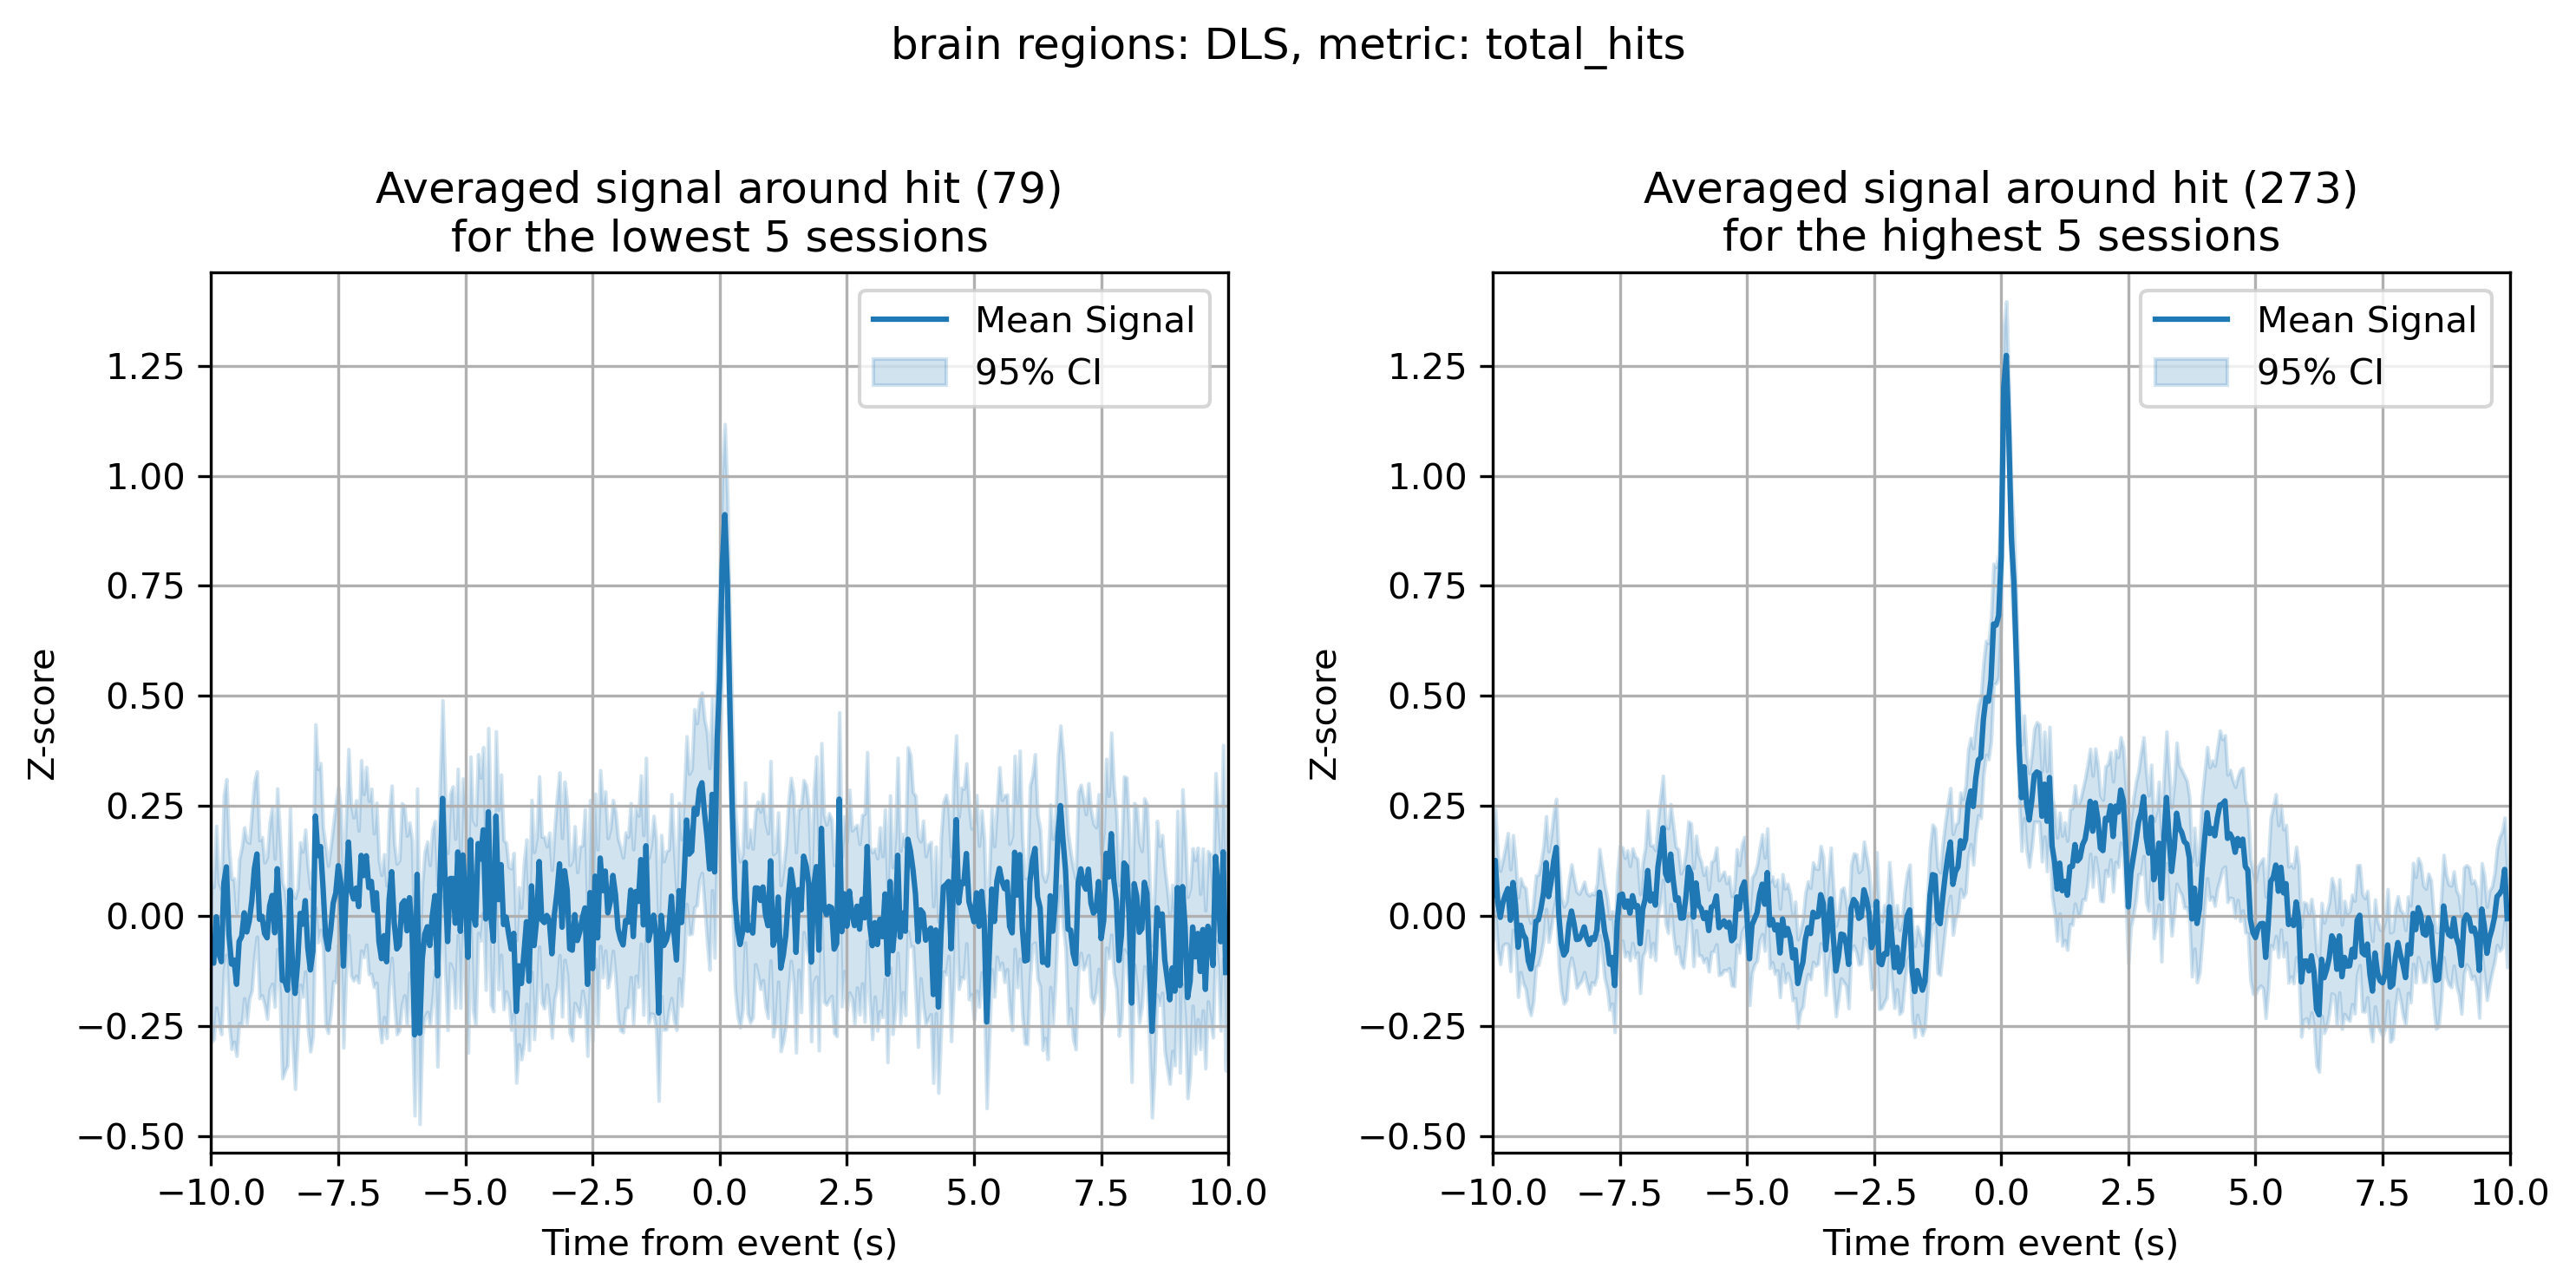

In [28]:
all_colors = ['purple', 'forestgreen', 'C0']

def brain_reg_in_session(brain_regions, event_type, session):
    return ((brain_regions[0] in session.brain_regions or brain_regions[1] in session.brain_regions)
            and session.timepoints_container.get_data(event_type))

for metric, session_order in metric_session_order.items():
    # worst_sessions = [sessions[i] for i in session_order[:5]]
    # best_sessions = [sessions[i] for i in session_order[-5:]]

    for brain_regions, color in zip([['VS_left', 'VS_right']],
                                      all_colors):
    # for brain_regions, color in zip([['VS_left', 'VS_right'], ['DMS_left', 'DMS_right'], ['DLS_left', 'DLS_right']],
    #                                  all_colors):
        for event_type in ['hit']:
        #for event_type in ['hit', 'mistake', 'miss', 'cor_reject', 'reward_collect', 'before_dispimg_miss']:
            filtered_sessions = [sesh if brain_reg_in_session(brain_regions, event_type, sesh) 
                                 else None for sesh in sessions]
            ordered_filtered_sessions = []
            for session_idx, session in zip(session_order, sessions):
                if filtered_sessions[session_idx] == None:
                    continue
                else:
                    ordered_filtered_sessions.append(filtered_sessions[session_idx])

            worst_sessions = ordered_filtered_sessions[:5]
            best_sessions = ordered_filtered_sessions[-5:]

            suffix = f"{metric}, {brain_regions[0].split('_')[0]}, {event_type}"

            #print(metric, brain_regions[0].split('_')[0], event_type)
            fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), ncols=2, dpi=300)
            
            worst_total = sum(len(session.timepoints_container.data.get(event_type, []))
                            for session in worst_sessions)
            
            best_total = sum(len(session.timepoints_container.data.get(event_type, []))
                            for session in best_sessions)

            bad_subtitle = f"Averaged signal around {event_type} ({worst_total})\nfor the lowest 5 sessions"
            good_subtitle = f"Averaged signal around {event_type} ({best_total})\nfor the highest 5 sessions"
            lb1, ub1 = aggregate_signals(worst_sessions, event_type, brain_regions, ax1, aggregate_by_session=False, 
                                         normalize_baseline=True, color=color, subtitle=bad_subtitle)
            lb2, ub2 = aggregate_signals(best_sessions, event_type, brain_regions, ax2, aggregate_by_session=False, 
                                         normalize_baseline=True, color=color, subtitle=good_subtitle)
            
            plt.suptitle(f"brain regions: {brain_regions[0].split('_')[0]}, metric: {metric}\n")

            brain_region_name = brain_regions[0].split('_')[0]
            lb = min(lb1, lb2)
            ub = max(ub1, ub2)
                    
            # if ub - lb < 3.5:
            #     plt.clf()
            #     continue
            for ax in (ax1, ax2):
                if (ub - lb) < 2:
                    ax.set_ylim((lb + ub) / 2 - 1, (lb + ub) / 2 + 1)    
                else:
                    ax.set_ylim(lb, ub)    
                ax.set_xlim(-10, 10)
                ax.grid()
            
            
            plt.tight_layout()
            plt.show()
            #plt.savefig(f'{metric}_{event_type}_{brain_region_name}.png', dpi=300)
        

